In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import numpy as np
import json
import pickle
import optuna
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler
from optuna.exceptions import TrialPruned
torch.manual_seed(0)
torch.set_float32_matmul_precision('high')

num_blocks = 1
data_per_block = 30000
N = num_blocks * data_per_block
num_params = 30
num_outputs = 6
n_components = 3
device = 'cuda'

param_sets = np.zeros((N, num_params))
outputs = np.zeros((N, num_outputs))
for i in range(num_blocks):
    with open("LIF_training_data_intelligent.pkl", 'rb') as handle:
    #with open(f'LIF_sims_{i+1}.pkl', 'rb') as handle:
        param_set, output = pickle.load(handle)
        param_sets[i * data_per_block : (i+1) * data_per_block] = param_set
        outputs[i * data_per_block : (i+1) * data_per_block] = output
# Filter to realistic excitatory rate
# Filter out single spike trials
input_train, input_test, output_train, output_test = train_test_split(param_sets, outputs, train_size = 0.9, random_state = 1)
# We take a logarithm to make the output scale-invariant
output_train = np.log1p(output_train)
output_test = np.log1p(output_test)

input_scaler = StandardScaler()
input_train_scaled = input_scaler.fit_transform(input_train)
input_test_scaled = input_scaler.transform(input_test)
output_scaler = StandardScaler()
output_train_scaled = output_scaler.fit_transform(output_train)
output_test_scaled = output_scaler.transform(output_test)
def add_noise(array, min_or_max):
    if min_or_max == "min":
        val = np.min(array)
        indices = np.where(array <= val + 1e-4)[0]
    else:
        val = np.max(array)
        indices = np.where(array >= val - 1e-4)[0]
    noise = np.random.randn(len(indices)) * 1e-4
    array[indices] = array[indices] + noise
    return array
output_train_scaled[:, 2] = add_noise(output_train_scaled[:, 2], "min")
output_train_scaled[:, 5] = add_noise(output_train_scaled[:, 5], "min")
output_test_scaled[:, 2] = add_noise(output_test_scaled[:, 2], "min")
output_test_scaled[:, 5] = add_noise(output_test_scaled[:, 5], "min")
"""
output_scaler = QuantileTransformer(output_distribution = 'normal')
output_train_scaled = output_scaler.fit_transform(output_train)
output_test_scaled = output_scaler.transform(output_test)
"""

input_train_tensor = torch.tensor(input_train_scaled, dtype=torch.float32).to(device)
output_train_tensor = torch.tensor(output_train_scaled, dtype=torch.float32).to(device)
input_test_tensor = torch.tensor(input_test_scaled, dtype=torch.float32).to(device)
output_test_tensor = torch.tensor(output_test_scaled, dtype=torch.float32).to(device)

def mdn_loss(y_pred, y_true, n_components):
    """
    Calculates the Mixture Density Network loss. Works on batches of any size.
    """
    num_outputs = y_true.shape[-1]
    
    split_sizes = [n_components, n_components * num_outputs, n_components * num_outputs]
    log_pi_raw, mu, log_sigma = torch.split(y_pred, split_sizes, dim=-1)
    mu = mu.reshape(-1, n_components, num_outputs)
    log_sigma = log_sigma.reshape(-1, n_components, num_outputs)
    pi = D.Categorical(logits=log_pi_raw)
    sigma = torch.exp(log_sigma)
    gaussians = D.Normal(loc=mu, scale=sigma)
    y_true_unsqueezed = y_true.unsqueeze(1)
    log_probs = gaussians.log_prob(y_true_unsqueezed)
    log_probs = torch.sum(log_probs, dim=2)
    total_log_likelihood = torch.logsumexp(pi.logits + log_probs, dim=1)

    return -torch.mean(total_log_likelihood)

def train_step(model, optimizer, gradscaler, input_batch, output_batch, n_components):
    """Compiled function for a single training step."""
    optimizer.zero_grad(set_to_none=True)
    with autocast('cuda'):
        model_output = model(input_batch)
        loss = mdn_loss(model_output, output_batch, n_components)
    
    gradscaler.scale(loss).backward()
    gradscaler.step(optimizer)
    gradscaler.update()
    return loss

def val_step(model, input_test_tensor, output_test_tensor, n_components):
    """Compiled function for the validation step."""
    with torch.no_grad():
        with autocast('cuda'):
            model_output = model(input_test_tensor)
            avg_test_loss = mdn_loss(model_output, output_test_tensor, n_components)
    return avg_test_loss

def objective(trial):
    n_components = 3
    n_layer1 = trial.suggest_int("n_layer1", 64, 512, log=True)
    n_layer2 = trial.suggest_int("n_layer2", 32, 256, log=True)
    n_layer3 = trial.suggest_int("n_layer3", 16, 64, log=True)
    lr = trial.suggest_float("lr", 1e-3, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    use_amsgrad = trial.suggest_categorical("amsgrad", [True, False])
    activation_name = trial.suggest_categorical("activation", ["GELU", "Tanh"])
    activation_functions = {
        "GELU": nn.GELU(),
        "Tanh": nn.Tanh()
    }
    activation_fn = activation_functions[activation_name]

    model = nn.Sequential(nn.Linear(num_params, n_layer1),
                          activation_fn,
                          nn.Linear(n_layer1, n_layer2),
                          activation_fn,
                          nn.Linear(n_layer2, n_layer3),
                          activation_fn,
                          nn.Linear(n_layer3, n_components * (2* num_outputs + 1))
                         ).to(device)
    
    final_layer = model[-1]
    torch.nn.init.zeros_(final_layer.bias[:num_outputs])
    torch.nn.init.constant_(final_layer.bias[num_outputs:], -2.0)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad = use_amsgrad)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

    epochs = 75
    gradscaler = GradScaler('cuda')

    for epoch in range(epochs):
        model.train()
        indices = torch.randperm(input_train_tensor.size(0))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            input_batch = input_train_tensor[batch_indices]
            output_batch = output_train_tensor[batch_indices]
            loss = train_step(model, optimizer, gradscaler, input_batch, output_batch, n_components)

        model.eval()
        avg_test_loss = val_step(model, input_test_tensor, output_test_tensor, n_components).item()
        scheduler.step(avg_test_loss)
        trial.report(avg_test_loss, epoch)
        
        if trial.should_prune():
            raise TrialPruned()

    return avg_test_loss

learn = True

if __name__ == "__main__":
    if learn:
        sampler = optuna.samplers.TPESampler(n_startup_trials=5)
        pruner = optuna.pruners.MedianPruner(n_startup_trials=5)
        study = optuna.create_study(direction="minimize", pruner=pruner, sampler = sampler)
        
        study.optimize(objective, n_trials=50)
    
        # Print the results
        print("Number of finished trials: ", len(study.trials))
        print("Best trial:")
        trial = study.best_trial
        print("  Value (Best Test Loss): ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

[I 2025-08-28 23:53:29,293] A new study created in memory with name: no-name-fdbb7f92-5ca7-4631-bd25-a314db507032
[I 2025-08-28 23:54:15,303] Trial 0 finished with value: -5.034176826477051 and parameters: {'n_layer1': 167, 'n_layer2': 218, 'n_layer3': 34, 'lr': 0.009526349046955786, 'weight_decay': 2.4051940326613055e-06, 'batch_size': 128, 'amsgrad': True, 'activation': 'Tanh'}. Best is trial 0 with value: -5.034176826477051.
[I 2025-08-28 23:58:49,632] Trial 1 finished with value: -7.538440227508545 and parameters: {'n_layer1': 146, 'n_layer2': 32, 'n_layer3': 46, 'lr': 0.002582115816253961, 'weight_decay': 0.00098546198074197, 'batch_size': 32, 'amsgrad': False, 'activation': 'Tanh'}. Best is trial 1 with value: -7.538440227508545.
[I 2025-08-29 00:00:23,668] Trial 2 finished with value: -4.76796293258667 and parameters: {'n_layer1': 110, 'n_layer2': 49, 'n_layer3': 22, 'lr': 0.0033398507011339683, 'weight_decay': 0.0024711527906172617, 'batch_size': 64, 'amsgrad': True, 'activatio

ValueError: Expected parameter scale (Tensor of shape (32, 3, 6)) of distribution Normal(loc: torch.Size([32, 3, 6]), scale: torch.Size([32, 3, 6])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[7.6448e-01, 9.4002e-01, 6.2670e-01, 5.2243e+00, 1.1324e+00,
          2.5358e-01],
         [3.7950e-02, 2.1669e-01, 7.2157e-02, 6.1308e-01, 2.0376e-01,
          1.8283e-01],
         [1.7152e+00, 1.1784e+00, 2.2017e+01, 4.7528e+01, 3.0772e+00,
          8.6218e+00]],

        [[1.3963e-01, 2.4747e-01, 2.3752e-01, 3.9584e-01, 2.9647e-01,
          2.7688e-01],
         [1.5607e-01, 1.5172e-01, 6.5828e-02, 7.7414e-02, 7.1834e-01,
          5.7754e-02],
         [4.8927e-01, 3.0768e-01, 2.1503e+00, 2.4355e+00, 2.0489e+00,
          2.9647e-01]],

        [[1.0336e-01, 1.9710e-01, 1.9788e-01, 2.7688e-01, 2.7580e-01,
          2.0737e-01],
         [1.7259e-01, 1.6404e-01, 5.8321e-02, 9.7669e-02, 4.4964e-01,
          6.6996e-02],
         [2.8317e-01, 2.6036e-01, 1.0436e+00, 1.0377e+00, 1.4109e+00,
          2.8511e-01]],

        [[2.5358e-01, 7.1275e-01, 9.6284e-01, 1.4220e+00, 9.2479e-01,
          1.3708e+00],
         [8.2406e-02, 1.2664e-01, 7.3008e-02, 1.4576e-01, 1.0423e+00,
          3.5790e-02],
         [1.4862e+00, 1.1478e+00, 1.2182e+01, 1.5460e+01, 1.0772e+01,
          1.9742e+00]],

        [[1.2889e-01, 1.5024e-01, 2.7020e-01, 2.3315e-01, 2.0217e-01,
          2.8069e-01],
         [1.1419e-01, 1.3922e-01, 1.9519e-01, 2.5657e-01, 2.5607e-01,
          7.7868e-02],
         [1.8444e-01, 1.7668e-01, 3.9972e-01, 3.5001e-01, 4.7306e-01,
          6.5198e-01]],

        [[7.8173e-02, 1.1804e-01, 7.9095e-02, 1.5068e-01, 1.4420e-01,
          9.5593e-02],
         [1.6925e-01, 1.2203e-01, 1.3402e-01, 8.1446e-02, 3.2339e-01,
          6.4681e-02],
         [1.5306e-01, 1.2889e-01, 2.3799e-01, 2.6420e-01, 4.8380e-01,
          1.3041e-01]],

        [[1.2615e-01, 1.2939e-01, 2.0277e-01, 4.1382e-01, 2.8567e-01,
          1.8052e-01],
         [1.4031e-01, 1.8176e-01, 1.6728e-01, 1.3720e-01, 4.1221e-01,
          7.9249e-02],
         [2.4747e-01, 1.6859e-01, 5.2748e-01, 7.4441e-01, 6.7301e-01,
          2.6087e-01]],

        [[1.8808e-01, 2.6087e-01, 6.0526e-02, 2.3089e-01, 2.7499e-01,
          2.9268e-02],
         [6.2691e-02, 1.4128e-01, 1.1576e-01, 3.3268e-01, 1.0236e-01,
          8.8755e-02],
         [2.1023e-01, 2.2488e-01, 6.2502e-01, 7.7994e-01, 6.0210e-01,
          1.1945e+00]],

        [[3.5691e-01, 6.5294e-01, 3.3731e+00, 2.1378e+00, 9.4323e-01,
          4.0687e+00],
         [9.1572e-02, 2.0961e-01, 5.0472e-02, 1.9576e-01, 1.8728e+00,
          4.2502e-02],
         [2.1927e+00, 9.3296e-01, 4.0023e+01, 3.9479e+01, 1.1223e+01,
          2.4606e+00]],

        [[9.4849e-02, 1.9768e-01, 1.1419e-01, 1.6071e-01, 1.7565e-01,
          1.3613e-01],
         [2.0316e-01, 1.4239e-01, 6.2204e-02, 5.2688e-02, 4.7306e-01,
          7.7868e-02],
         [2.8595e-01, 2.3225e-01, 8.8260e-01, 6.5598e-01, 9.9505e-01,
          1.5531e-01]],

        [[6.0240e-01, 1.6216e+00, 1.8099e+00, 1.9897e+00, 1.4618e+00,
          9.2680e+00],
         [5.8207e-02, 1.7445e-01, 5.0769e-02, 2.4554e-01, 1.2385e+00,
          2.8037e-02],
         [2.4426e+00, 2.1274e+00, 6.6374e+01, 4.8941e+01, 2.2894e+01,
          7.2391e+00]],

        [[3.7440e-01, 8.4962e-01, 3.7010e+00, 2.9593e+00, 9.4629e-01,
          8.1312e+00],
         [7.8021e-02, 2.2139e-01, 4.1843e-02, 2.7499e-01, 1.1880e+00,
          4.3425e-02],
         [2.0210e+00, 1.0391e+00, 5.4598e+01, 5.5026e+01, 1.0001e+01,
          4.1046e+00]],

        [[7.0074e-02, 1.2615e-01, 6.9258e-02, 1.2155e-01, 1.2322e-01,
          1.0478e-01],
         [1.9576e-01, 1.1352e-01, 9.2833e-02, 5.9587e-02, 3.6573e-01,
          5.7867e-02],
         [1.6245e-01, 1.3015e-01, 2.7126e-01, 2.8932e-01, 5.3058e-01,
          1.1220e-01]],

        [[4.6800e-01, 9.4747e-01, 3.0503e+00, 6.0485e+00, 1.2505e+00,
          6.2649e+00],
         [6.5062e-02, 1.6582e-01, 7.5473e-02, 2.9850e-01, 9.8686e-01,
          4.8161e-02],
         [2.4283e+00, 1.6039e+00, 4.3615e+01, 7.0105e+01, 1.2423e+01,
          4.4599e+00]],

        [[8.4386e+00, 1.1333e+01, 1.3905e-03, 8.5022e-02, 4.3432e-01,
          3.1971e+01],
         [4.4023e-02, 1.4576e-01, 3.5167e-02, 6.6996e-02, 9.4295e-02,
          2.7334e-02],
         [5.3683e-01, 4.5124e+00, 4.5087e+01, 2.8683e+00, 6.3511e+00,
          2.2879e+00]],

        [[7.0900e-02, 1.3168e-01, 7.3868e-02, 1.0960e-01, 1.2155e-01,
          1.0196e-01],
         [2.2032e-01, 1.2964e-01, 9.3744e-02, 5.0670e-02, 3.7459e-01,
          7.6811e-02],
         [1.6975e-01, 1.4183e-01, 3.1620e-01, 2.5309e-01, 4.9455e-01,
          9.7098e-02]],

        [[3.4290e-01, 4.2075e-01, 1.5791e-01, 1.0864e+00, 7.4568e-01,
          5.0080e-02],
         [4.7137e-02, 1.9519e-01, 8.3704e-02, 4.5672e-01, 1.9807e-01,
          9.9207e-02],
         [5.4396e-01, 4.6391e-01, 2.3582e+00, 6.0014e+00, 1.8456e+00,
          3.4429e+00]],

        [[2.6061e-01, 3.7349e-01, 8.9448e-01, 8.2238e-01, 4.8689e-01,
          1.1160e+00],
         [1.1667e-01, 1.9826e-01, 7.9404e-02, 1.4004e-01, 9.8747e-01,
          6.4053e-02],
         [9.3165e-01, 5.0063e-01, 7.6684e+00, 6.4009e+00, 3.2123e+00,
          8.7009e-01]],

        [[7.1456e-02, 1.2419e-01, 6.3307e-02, 1.4169e-01, 1.3573e-01,
          8.8582e-02],
         [1.9424e-01, 1.1220e-01, 1.0377e-01, 5.6087e-02, 3.7422e-01,
          5.8778e-02],
         [1.6925e-01, 1.3854e-01, 2.5657e-01, 3.0918e-01, 5.7425e-01,
          1.0038e-01]],

        [[3.9719e-01, 5.2774e-01, 1.7310e-01, 9.5049e-01, 8.7190e-01,
          5.7081e-02],
         [4.0556e-02, 1.6229e-01, 7.1456e-02, 4.6482e-01, 2.1989e-01,
          7.0074e-02],
         [6.9828e-01, 5.5794e-01, 3.8938e+00, 8.0051e+00, 2.8964e+00,
          4.2974e+00]],

        [[1.2419e-01, 1.0322e+00, 2.7073e-01, 3.3300e-01, 4.4723e-01,
          9.6190e-01],
         [9.1215e-02, 1.6341e-01, 3.6425e-02, 7.4885e-02, 4.4115e-01,
          3.8173e-02],
         [7.4024e-01, 8.3024e-01, 1.0400e+01, 5.0340e+00, 4.8648e+00,
          1.3628e+00]],

        [[8.2348e-01, 9.6951e-01, 5.2722e-01, 5.1836e+00, 1.2554e+00,
          1.4676e-01],
         [3.5098e-02, 2.5507e-01, 6.6474e-02, 6.6290e-01, 2.3915e-01,
          1.9424e-01],
         [1.7312e+00, 1.2015e+00, 1.9852e+01, 5.4812e+01, 3.5661e+00,
          1.1670e+01]],

        [[1.3412e+17, 1.5221e+14, 7.8942e-28, 9.0806e-06, 1.8979e+01,
          8.3677e+22],
         [1.8526e-04, 4.6046e-02, 4.4763e-08, 5.6382e-06, 1.0862e-09,
          4.6184e-08],
         [3.0673e-02, 7.1187e+12, 4.2329e+10, 1.7180e+01, 2.1947e+06,
          2.0140e+06]],

        [[       inf,        inf, 0.0000e+00, 9.8629e-15, 9.9820e+00,
                 inf],
         [2.0936e-09, 1.1240e-02, 2.5012e-21, 2.6284e-16, 2.4840e-28,
          7.6169e-19],
         [4.0886e+00,        inf, 4.6601e+26, 2.1868e+08, 3.6043e+19,
          7.4805e+17]],

        [[       inf, 4.0136e+33, 0.0000e+00, 2.1724e-10, 6.2405e+00,
                 inf],
         [3.6327e-07, 5.5209e-03, 1.4660e-15, 3.0508e-12, 5.0239e-20,
          5.6757e-14],
         [3.5074e+00, 2.3630e+30, 3.2125e+20, 2.4922e+07, 9.5248e+13,
          2.9971e+13]],

        [[6.9123e-02, 1.5127e-01, 9.3927e-02, 1.2084e-01, 1.7531e-01,
          1.1067e-01],
         [2.0737e-01, 1.3246e-01, 5.6416e-02, 8.0655e-02, 2.7312e-01,
          7.3724e-02],
         [1.5010e-01, 1.9691e-01, 3.4290e-01, 2.6575e-01, 7.4897e-01,
          1.7462e-01]],

        [[4.8641e-01, 5.3370e-01, 2.6010e-01, 2.4546e+00, 6.5710e-01,
          9.8627e-02],
         [5.2895e-02, 2.2010e-01, 7.1317e-02, 4.1686e-01, 2.9045e-01,
          2.0396e-01],
         [8.2348e-01, 7.2150e-01, 2.9478e+00, 1.0814e+01, 1.6463e+00,
          5.7602e+00]],

        [[2.0119e-01, 2.2053e-01, 8.0497e-02, 3.4694e-01, 3.7331e-01,
          2.7281e-02],
         [6.9393e-02, 2.1924e-01, 1.4676e-01, 3.5001e-01, 1.2061e-01,
          1.3376e-01],
         [2.2291e-01, 2.1479e-01, 6.3285e-01, 9.0117e-01, 5.3500e-01,
          1.0571e+00]],

        [[5.0185e-01, 6.4581e-01, 3.1069e-01, 2.3965e+00, 8.0854e-01,
          1.4114e-01],
         [4.4368e-02, 1.7175e-01, 6.3060e-02, 4.7468e-01, 2.3985e-01,
          1.2492e-01],
         [9.8464e-01, 7.9581e-01, 5.7659e+00, 1.5889e+01, 2.4884e+00,
          6.0544e+00]],

        [[3.8723e-01, 4.0661e-01, 8.9399e-01, 9.9203e-01, 6.0623e-01,
          1.1789e+00],
         [4.9690e-02, 1.0057e-01, 1.5931e-01, 5.9800e-01, 4.5030e-01,
          3.5790e-02],
         [6.5630e-01, 6.1443e-01, 2.6631e+00, 3.4903e+00, 3.0414e+00,
          4.8270e+00]],

        [[1.1419e+00, 1.4289e+00, 8.7041e-01, 1.3250e+01, 1.3792e+00,
          3.1313e-01],
         [3.2334e-02, 2.2731e-01, 4.8255e-02, 7.1032e-01, 3.1806e-01,
          2.3361e-01],
         [2.8964e+00, 2.0519e+00, 3.6727e+01, 1.6173e+02, 5.3325e+00,
          2.2804e+01]],

        [[2.2488e-01, 3.3463e-01, 7.4013e-02, 2.0138e-01, 2.5808e-01,
          4.2336e-02],
         [6.0644e-02, 1.2347e-01, 9.2652e-02, 3.0948e-01, 1.1176e-01,
          8.7379e-02],
         [2.7445e-01, 2.7472e-01, 1.0361e+00, 9.2333e-01, 6.9268e-01,
          1.4884e+00]]], device='cuda:0', grad_fn=<ExpBackward0>)

In [18]:
if learn:
    trial = study.best_trial
    params = trial.params
    with open('trial_params.pkl', 'wb') as handle:
        pickle.dump(params, handle)
else:
    with open('trial_params.pkl', 'rb') as handle:a
        params = pickle.load(handle)

param_labels = ["$S^{EE}$", "$S^{EPV}$", "$S^{ESOM}$", "$S^{PVE}$", "$S^{PVPV}$", "$S^{PVSOM}$", "$S^{SOME}$", "$S^{SOMPV}$", "$S^{SOMSOM}$",
                "$\lambda_E$", "$\lambda_{PV}$", "$\lambda_{lat}$", "$df_{EE}$", "$df_{EPV}$", "$df_{ESOM}$", "$df_{PVE}$", "$df_{PVPV}$", 
                "$df_{PVSOM}$", "$df_{SOME}$", "$df_{SOMPV}$", "$df_{SOMSOM}$", "$\\tau^D_{EE}$", "$\\tau^D_{EPV}$", "$\\tau^D_{ESOM}$",
               " $\\tau^D_{PVE}$", "$\\tau^D_{PVPV}$", "$\\tau^D_{PVSOM}$", "$\\tau^D_{SOME}$", "$\\tau^D_{SOMPV}$", "$\\tau^D_{SOMSOM}$"]

In [19]:
torch.manual_seed(0)

n_layer1 = params['n_layer1']
n_layer2 = params['n_layer2']
n_layer3 = params['n_layer3']
lr = params['lr']
weight_decay = params['weight_decay']
batch_size = params['batch_size']
use_amsgrad = params['amsgrad']
activation_name = params['activation']
activation_functions = {
    "ReLU": nn.ReLU(),
    "GELU": nn.GELU(),
    "Tanh": nn.Tanh(),
    "Sigmoid": nn.Sigmoid()
}
activation_fn = activation_functions[activation_name]
"""
n_layer1 = 129
n_layer2 = 167
n_layer3 = 60
lr = 0.009819009301789293
weight_decay = 0.0002024528064672795
batch_size = 64
use_amsgrad = True
activation_fn = nn.GELU()
"""

def mdn_loss(y_pred, y_true, n_components):
    """
    Calculates the Mixture Density Network loss. Works on batches of any size.
    """
    num_outputs = y_true.shape[-1]
    
    # Define the sizes of the splits for pi, mu, and sigma
    split_sizes = [n_components, n_components * num_outputs, n_components * num_outputs]
    
    # Use torch.split for safer slicing
    log_pi_raw, mu, log_sigma = torch.split(y_pred, split_sizes, dim=-1)

    # Reshape mu and log_sigma for the distribution
    mu = mu.reshape(-1, n_components, num_outputs)
    log_sigma = log_sigma.reshape(-1, n_components, num_outputs)
    
    # Apply activations to enforce constraints
    pi = D.Categorical(logits=log_pi_raw)
    sigma = torch.exp(log_sigma)

    # Create the mixture of Gaussian distributions
    gaussians = D.Normal(loc=mu, scale=sigma)
    
    # Unsqueeze y_true to prepare for broadcasting against the K components
    y_true_unsqueezed = y_true.unsqueeze(1)
    
    # Calculate the log probability of the true data under each component
    log_probs = gaussians.log_prob(y_true_unsqueezed)
    log_probs = torch.sum(log_probs, dim=2)
    
    # Weight the probabilities by the mixing coefficients (log-sum-exp trick)
    total_log_likelihood = torch.logsumexp(pi.logits + log_probs, dim=1)

    # Return the mean negative log likelihood
    return -torch.mean(total_log_likelihood)


class DNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(num_params, n_layer1),
                      activation_fn,
                      nn.Linear(n_layer1, n_layer2),
                      activation_fn,
                      nn.Linear(n_layer2, n_layer3),
                      activation_fn,
                      nn.Linear(n_layer3, n_components * (2* num_outputs + 1))
                     )

    def forward(self, x):
        return self.network(x)
if learn:
    model = DNN().to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad = use_amsgrad)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)
    
    epochs = 100
    gradscaler = GradScaler('cuda')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        indices = torch.randperm(input_train_tensor.size(0))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            input_batch = input_train_tensor[batch_indices]
            output_batch = output_train_tensor[batch_indices]
            optimizer.zero_grad(set_to_none=True)
            with autocast('cuda'):
                model_output = model(input_batch)
                loss = mdn_loss(model_output, output_batch, n_components)
            train_loss += loss.item()
            gradscaler.scale(loss).backward()
            gradscaler.step(optimizer)
            gradscaler.update()
        avg_train_loss = train_loss / (len(indices) / batch_size)
    
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            with autocast('cuda'):
                model_output = model(input_test_tensor)
                mean = model_output[:, :num_outputs]
                log_var = model_output[:, num_outputs:]
                total_test_loss += mdn_loss(model_output, output_test_tensor, n_components).item()
        
        avg_test_loss = total_test_loss
        scheduler.step(avg_test_loss)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")

Epoch: 0, Train Loss: -0.564435777982076, Test Loss: -3.3638246059417725
Epoch: 10, Train Loss: -5.756455199065032, Test Loss: -5.44447660446167
Epoch: 20, Train Loss: -6.181975248266149, Test Loss: -6.272671699523926
Epoch: 30, Train Loss: -6.539044031213831, Test Loss: -6.616230487823486
Epoch: 40, Train Loss: -6.690222527115433, Test Loss: -6.0745415687561035
Epoch: 50, Train Loss: -8.374602536236798, Test Loss: -7.82211971282959
Epoch: 60, Train Loss: -8.814019083658854, Test Loss: -8.099468231201172
Epoch: 70, Train Loss: -8.89216603427463, Test Loss: -8.175907135009766
Epoch: 80, Train Loss: -8.9109191148546, Test Loss: -8.169474601745605
Epoch: 90, Train Loss: -8.964087343004016, Test Loss: -8.192432403564453


In [20]:
if learn:
    torch.save(model.state_dict(), "LIF_DNN_3_neuron_stochastic_weights_MDN.pth")
else:
    model = DNN().to(device)
    model.load_state_dict(torch.load('LIF_DNN_3_neuron_stochastic_weights_MDN.pth'))

In [21]:
import torch
import torch.nn.functional as F
import torch.distributions as D

def weighted_hybrid_mdn_mse_loss(y_pred, y_true, n_components, weights, alpha=1.0):
    """
    Calculates a hybrid loss combining the MDN NLL with a WEIGHTED MSE term.

    Args:
        y_pred: The raw output tensor from the MDN model.
        y_true: The ground truth target tensor.
        n_components: The number of mixture components.
        weights: A tensor of weights for each output variable.
        alpha: The overall weight of the MSE term.
    """
    num_outputs = y_true.shape[-1]
    split_sizes = [n_components, n_components * num_outputs, n_components * num_outputs]
    log_pi_raw, mu, log_sigma = torch.split(y_pred, split_sizes, dim=-1)
    mu = mu.reshape(-1, n_components, num_outputs)
    log_sigma = log_sigma.reshape(-1, n_components, num_outputs)
    pi = D.Categorical(logits=log_pi_raw)
    sigma = torch.exp(log_sigma)
    gaussians = D.Normal(loc=mu, scale=sigma)
    y_true_unsqueezed = y_true.unsqueeze(1)
    log_probs = gaussians.log_prob(y_true_unsqueezed)
    weights_unsqueezed = weights.unsqueeze(1)
    masked_log_probs = log_probs * weights_unsqueezed
    log_probs_summed = torch.sum(masked_log_probs, dim=2)
    total_log_likelihood = torch.logsumexp(pi.logits + log_probs_summed, dim=1)
    nll_loss = -torch.mean(total_log_likelihood)

    # --- 2. Calculate the Weighted MSE Loss ---
    predicted_mus = torch.sum(pi.probs.unsqueeze(-1) * mu, dim=1)
    
    # Calculate the squared error for each output variable individually
    squared_error = (predicted_mus - y_true)**2
    
    # Apply the weights to each error term
    weighted_squared_error = squared_error * weights
    
    # The final MSE loss is the mean of the weighted errors
    mse_loss = torch.mean(weighted_squared_error)
    
    return nll_loss + alpha * mse_loss

In [36]:
import LIF_sim
import importlib
import torch.nn.functional as F
importlib.reload(LIF_sim)
from multiprocessing import Pool
np.set_printoptions(suppress = True, precision = 6, linewidth = 100000000000000)

if __name__ == "__main__":
    fit_CVs = True
    model.eval()
    #targets_np = np.array([[3, 11, 0, 1.0, 1.0, 0]])
    """
    loss_weights = torch.tensor([[2.0, 1.0, 1.0, 1.0, 1.0, 0.0],
                                 [2.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                                 [2.0, 1.0, 1.0, 1.0, 1.0, 1.0]], device=device)
    """
    loss_weights = torch.tensor([[2.0, 1.0, 1.0, 1.0, 1.0, 1.0]], device=device)
    loss_weights_np = loss_weights.cpu().detach().numpy()
    """
    targets_np = np.array([[3, 11, 0, 0.9, 1.1, 0], 
                           [10, 45, 7, 0.6, 0.6, 1.7], 
                           [25, 110, 20, 0.5, 0.5, 1.7]])
    """
    targets_np = np.array([[20, 80, 15, 1, 0.8, 1.6]])
    target = torch.tensor(output_scaler.transform(np.log1p(targets_np))).to(device).float()
    if fit_CVs:
        print("Optimization target: Rates and CVs")
        labels = ["r_E", "r_PV", "r_SOM", "cv_E", "cv_PV", "cv_SOM"]
    else:
        print("Optimization target: Rates ONLY")
        labels = ["r_E", "r_PV", "r_SOM"]
    
    variable_param_indices = np.array([9, 10, 11])
    common_param_indices = np.setdiff1d(np.arange(num_params), variable_param_indices)
    init_params_scaled = torch.tensor(input_train_scaled[-1], device=device, dtype=torch.float32)
    common_params_scaled = init_params_scaled[common_param_indices].unsqueeze(0)
    initial_variable_scaled = init_params_scaled[variable_param_indices]  
    num_targets = len(targets_np)
    variable_params_scaled = initial_variable_scaled.unsqueeze(0).repeat(num_targets, 1) 
    common_params_scaled.requires_grad = True
    variable_params_scaled.requires_grad = True
    
    optimizer = torch.optim.AdamW([common_params_scaled, variable_params_scaled], lr=0.02, weight_decay=0.05)
    best_score = np.inf
    best_params = None
    test_real_outputs = None
    weight = 50
    num_steps = 100000

    for i in range(num_steps):
        optimizer.zero_grad()
        full_params = torch.zeros(num_targets, num_params, device=device)
        full_params[:, common_param_indices] = common_params_scaled.expand(num_targets, -1)
        full_params[:, variable_param_indices] = variable_params_scaled
        
        output = model(full_params)
        if fit_CVs:
            """
            split_sizes = [n_components, n_components * num_outputs, n_components * num_outputs]
            pi_logits, mu, log_sigma = torch.split(output, split_sizes, dim=-1)
            pi = F.softmax(pi_logits, dim=-1)
            choice = torch.argmax(pi)
            sigma = torch.exp(log_sigma)
            mu = mu.reshape(-1, n_components, num_outputs)[:, choice]
            loss = mdn_loss(output, target, n_components=n_components)# + 0.1*F.mse_loss(mu, target)
            """
            loss = weighted_hybrid_mdn_mse_loss(
                output, 
                target, 
                n_components=n_components, 
                weights=loss_weights,
                alpha=1.0
            )
        else:
            target_for_loss = target[:, :3]
            split_sizes = [n_components, n_components * num_outputs, n_components * num_outputs]
            log_pi_raw, mu_6D, log_sigma_6D = torch.split(output, split_sizes, dim=-1)
    
            # 3. Reshape and slice mu and sigma to get parameters for only the 3 rates
            mu_6D_reshaped = mu_6D.reshape(-1, n_components, num_outputs)
            log_sigma_6D_reshaped = log_sigma_6D.reshape(-1, n_components, num_outputs)
    
            mu_rates = mu_6D_reshaped[:, :, :3]
            log_sigma_rates = log_sigma_6D_reshaped[:, :, :3]
    
            # 4. Flatten and re-assemble a new, smaller output tensor containing only rate parameters
            mu_rates_flat = mu_rates.reshape(-1, n_components * 3)
            log_sigma_rates_flat = log_sigma_rates.reshape(-1, n_components * 3)
        
            output_for_loss = torch.cat([log_pi_raw, mu_rates_flat, log_sigma_rates_flat], dim=1)
            loss = mdn_loss(output_for_loss, target_for_loss, n_components=n_components)
                
        loss.backward()
        optimizer.step()
            
        if i % 200 == 0 or i == num_steps - 1:
            final_params_scaled_np = full_params.detach().cpu().numpy()
            final_params_np = input_scaler.inverse_transform(final_params_scaled_np)
    
            with Pool(processes=len(final_params_np)) as pool:
                real_outputs = np.array(pool.map(LIF_sim.run_simulation, final_params_np))
    
            MDN_loss = loss.item()
            if fit_CVs:
                RMSE = np.mean((targets_np - real_outputs)**2 / targets_np**2)#np.mean((targets_np*loss_weights_np - real_outputs*loss_weights_np)**2)#np.mean((targets_np - real_outputs)**2 / targets_np**2)
            else:
                # Compare only the first 3 columns (rates)
                RMSE = np.mean((targets_np[:, :3] - real_outputs[:, :3])**2)
            score = weight * RMSE + MDN_loss
            print(f"Iter: {i}, Loss: {MDN_loss:.4f}, Rel MSE: {RMSE:.4f}, score: {score:.4f}")
            if score < best_score and i > 0:
                labels = ["r_E", "r_PV", "r_SOM", "cv_E", "cv_PV", "cv_SOM"]

                for j in range(num_targets):
                    print(f"Target Set {j+1}")
                    print(f"{'Variable':<10} | {'Target':>18} | {'Actual':>10}")
                    print("-" * 44)
                    for k, label in enumerate(labels):
                        real = real_outputs[j, k]
                        target_val = targets_np[j, k]
                        print(f"{label:<10} | {target_val:>18.3f} | {real:>10.3f}")
                    print("-" * 44)
                best_score = score
                test_real_outputs  = real_outputs
                best_params = final_params_np
    
    final_params_np = best_params
    print(f"Final Optimized Parameters (3 sets):\n{final_params_np}")
    print(f"Final Outputs:\n{test_real_outputs}")
    print(f"Target Outputs:\n{targets_np}")

Optimization target: Rates and CVs
Iter: 0, Loss: 577.8474, Rel MSE: 1.5370, score: 654.6954
Iter: 200, Loss: 23.4054, Rel MSE: 10.3454, score: 540.6757
Target Set 1
Variable   |             Target |     Actual
--------------------------------------------
r_E        |             20.000 |     51.217
r_PV       |             80.000 |    125.152
r_SOM      |             15.000 |    130.294
cv_E       |              1.000 |      1.125
cv_PV      |              0.800 |      0.926
cv_SOM     |              1.600 |      0.887
--------------------------------------------
Iter: 400, Loss: 22.0483, Rel MSE: 10.7524, score: 559.6692
Iter: 600, Loss: 21.4332, Rel MSE: 10.3268, score: 537.7739
Target Set 1
Variable   |             Target |     Actual
--------------------------------------------
r_E        |             20.000 |     51.037
r_PV       |             80.000 |    118.561
r_SOM      |             15.000 |    130.294
cv_E       |              1.000 |      1.086
cv_PV      |              

KeyboardInterrupt: 

In [37]:
final_params = best_params[0]
labels = ["S_EE", "S_EPV", "S_ESOM", "S_PVE", "S_PVPV", "S_PVSOM", "S_SOME", "S_SOMPV", "S_SOMSOM", "lam_E", "lam_I", "lam_lat", "df_EE", "df_EPV", "df_ESOM",
          "df_PVE", "df_PVPV", "df_PVSOM", "df_SOME", "df_SOMPV", "df_SOMSOM", "td_EE", "td_EPV", "td_ESOM", "td_PVE", "td_PVPV", "td_PVSOM", "td_SOME", "td_SOMPV", "td_SOMSOM"]
print("Final Parameters:")
for i, (label, param) in enumerate(zip(labels, final_params)):
    print(f"{i}. {label}: {param}")

np.save("final_params.npy", final_params)

Final Parameters:
0. S_EE: 0.02031005173921585
1. S_EPV: 0.044614262878894806
2. S_ESOM: 0.014536923728883266
3. S_PVE: 0.020595019683241844
4. S_PVPV: 0.033624403178691864
5. S_PVSOM: 0.014792541041970253
6. S_SOME: 0.012306686490774155
7. S_SOMPV: 0.03393559902906418
8. S_SOMSOM: 0.0015148604288697243
9. lam_E: 1.8761159181594849
10. lam_I: 0.8438052535057068
11. lam_lat: 0.2611176371574402
12. df_EE: 0.6217929720878601
13. df_EPV: 0.38052648305892944
14. df_ESOM: 0.5117722749710083
15. df_PVE: 0.39261895418167114
16. df_PVPV: 0.48295456171035767
17. df_PVSOM: -0.9541295766830444
18. df_SOME: -0.22547295689582825
19. df_SOMPV: 0.46692654490470886
20. df_SOMSOM: 0.5718880295753479
21. td_EE: 0.03274655342102051
22. td_EPV: 0.009618043899536133
23. td_ESOM: 0.0031784523744136095
24. td_PVE: 0.04454773664474487
25. td_PVPV: 0.012175926007330418
26. td_PVSOM: 0.005279708653688431
27. td_SOME: 0.0008683925261721015
28. td_SOMPV: 0.010397635400295258
29. td_SOMSOM: 0.00763030257076025


In [35]:
from LIF_sim import run_simulation
import matplotlib.pylab as plt
import torch.nn.functional as F

def get_stats(output, n_components):
    split_sizes = [n_components, n_components * num_outputs, n_components * num_outputs]
    pi_logits, mu, log_sigma = torch.split(output, split_sizes, dim=-1)
    pi = F.softmax(pi_logits, dim=-1)
    choice = torch.argmax(pi)
    sigma = torch.exp(log_sigma)
    mu = mu.reshape(-1, n_components, num_outputs)[:, choice].detach().cpu().numpy()
    sigma = sigma.reshape(n_components, num_outputs)[choice].detach().cpu().numpy()

    sigma_log = sigma * output_scaler.scale_
    mu_log = output_scaler.inverse_transform(mu)
    real_mean = np.exp(mu_log + (sigma_log**2) / 2) - 1
    real_variance = (np.exp(sigma_log**2) - 1) * np.exp(2 * mu_log + sigma_log**2)
    real_std = np.sqrt(real_variance)

    return real_mean.squeeze(), real_std.squeeze()

    
tensor_params = torch.tensor(input_scaler.transform(best_params)).to(device).float()
model_output = model(tensor_params)
stats = np.array([get_stats(model_output[i], n_components = n_components) for i in range(model_output.shape[0])])
predicted_outputs, predicted_stds = stats[:, 0], stats[:, 1]
real_outputs = np.array([run_simulation(p)[:num_outputs] for p in best_params])
labels = ["r_E", "r_PV", "r_SOM", "cv_E", "cv_PV", "cv_SOM"]
print(f"{'Inverse Problem Results':>18}")

for j in range(num_targets):
    print(f"{'Variable':<10} | {'Predicted ± 2 SD':>18} | {'Actual':>10}")
    print("-" * 44) # Separator line
    for i, label in enumerate(labels):
        pred = predicted_outputs[j, i]
        std = predicted_stds[j, i]
        real = real_outputs[j, i]
        pred_str = f"{pred:.3f} ± {2*std:.3f}"
        print(f"{label:<10} | {pred_str:>18} | {real:>10.3f}")
    print("" * 44)

# 3. Print the final summary metric
print("-" * 44)
RMSE = np.sqrt(np.mean((predicted_outputs - real_outputs)**2))
print(f"{'RMSE':<23}: {RMSE:.3f}")

Inverse Problem Results
Variable   |   Predicted ± 2 SD |     Actual
--------------------------------------------
r_E        |     20.403 ± 7.154 |     30.330
r_PV       |    83.875 ± 17.281 |    142.303
r_SOM      |     13.232 ± 5.404 |     39.647
cv_E       |      1.042 ± 0.248 |      1.077
cv_PV      |      0.771 ± 0.153 |      0.716
cv_SOM     |      1.411 ± 1.167 |      1.493

--------------------------------------------
RMSE                   : 26.489


In [29]:
real_avg_test_outputs = np.expm1(output_test).mean(axis = 0)
model_output = model(torch.tensor(input_test_scaled).to(device).float())
predicted_outputs = np.zeros((model_output.shape[0], num_outputs))
predicted_stds = np.zeros((model_output.shape[0], num_outputs))
blowup_idx = []
for i in range(model_output.shape[0]):
    predicted_outputs[i], predicted_stds[i] = get_stats(model_output[None, i, :], n_components = n_components)
    if predicted_outputs[i, 5] > 15:
        predicted_outputs[i, 5] = 14
        predicted_stds[i, 5] = 14
        blowup_idx.append(i)
model_avg_test_outputs = predicted_outputs.mean(axis = 0)
mean_of_variances = np.mean(predicted_stds**2, axis = 0)
variance_of_means = np.var(predicted_outputs, axis = 0)
total_variance = mean_of_variances + variance_of_means
model_avg_uncertainty = np.sqrt(total_variance / predicted_outputs.shape[0])
#model_avg_stds = 1/np.sqrt(np.sum(1/predicted_stds**2, axis = 0)) # Inverse-variance weighting

print("Performance on Test Set")
print(f"{'Variable':<10} | {'Predicted ± SEM':>18} | {'Actual Average':>10}")
print("-" * 44) # Separator line

for i, label in enumerate(labels):
    pred = model_avg_test_outputs[i]
    real = real_avg_test_outputs[i]
    sem = model_avg_uncertainty[i]
    pred_str = f"{pred:.5f} ± {sem:.5f}"
    print(f"{label:<10} | {pred_str:>18} | {real:>10.5f}")

# 3. Print the final summary metric
print("-" * 44)
rel_mse = 100 * np.mean((real_avg_test_outputs - model_avg_test_outputs)**2 / real_avg_test_outputs **2)
print(f"{'Relative MSE':<23}: {rel_mse:.6f}%")

Performance on Test Set
Variable   |    Predicted ± SEM | Actual Average
--------------------------------------------
r_E        | 24.87692 ± 0.27545 |   24.61165
r_PV       | 86.26972 ± 0.46450 |   86.23837
r_SOM      | 42.96130 ± 0.92059 |   41.67812
cv_E       |  1.23646 ± 0.00290 |    1.23792
cv_PV      |  1.02969 ± 0.00339 |    1.02718
cv_SOM     |  2.05149 ± 0.04766 |    2.11135
--------------------------------------------
Relative MSE           : 0.031256%


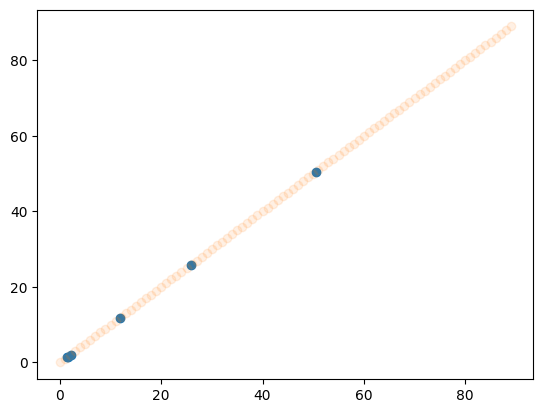

In [73]:
plt.scatter(model_avg_test_outputs, real_avg_test_outputs)
plt.scatter(np.arange(90), np.arange(90), alpha = 0.11)
#plt.xlim(0, 5)
#plt.ylim(0, 5)

C:\Users\Matt\AppData\Local\Temp\ipykernel_2340\3679842699.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stds_tensor = torch.tensor(output_stds, dtype=torch.float32, device=device)


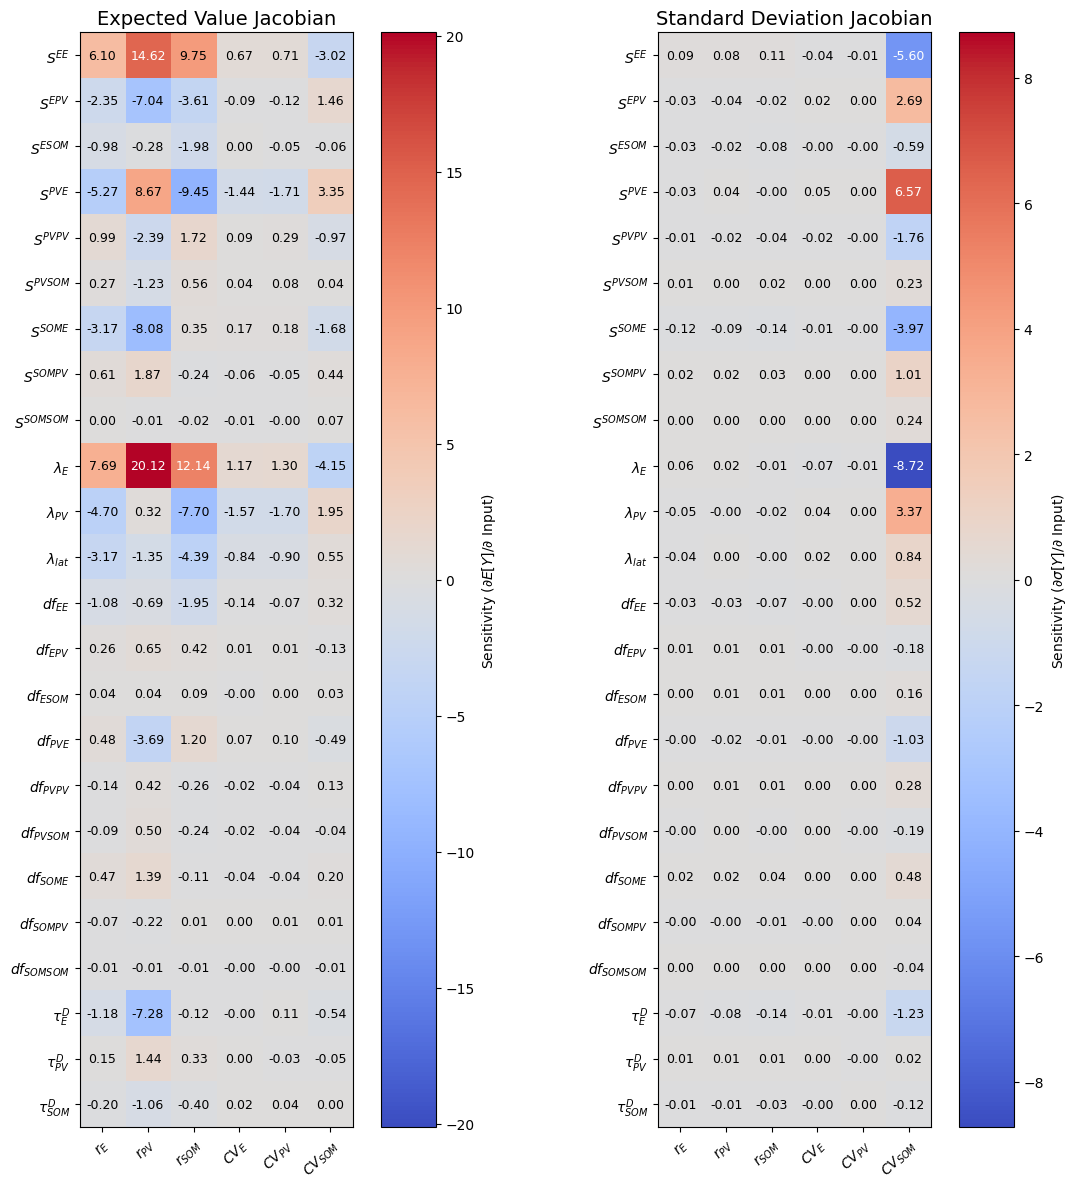

In [74]:
import torch
import torch.nn.functional as F

def get_stats(output, scaler, n_components):
    split_sizes = [n_components, n_components * num_outputs, n_components * num_outputs]
    pi_logits, mu_scaled, log_sigma_scaled = torch.split(output, split_sizes, dim=-1)
    scaler_mean = torch.tensor(scaler.mean_, dtype=torch.float32, device=device)
    scaler_scale = torch.tensor(scaler.scale_, dtype=torch.float32, device=device)
    mu_scaled = mu_scaled.reshape(-1, n_components, num_outputs)
    log_sigma_scaled = log_sigma_scaled.reshape(-1, n_components, num_outputs)
    pi = F.softmax(pi_logits, dim=-1)
    winner_idx = torch.argmax(pi, dim = -1)
    winner_idx_expanded = winner_idx.view(-1, 1, 1).expand(-1, 1, num_outputs)
    
    mu_scaled_winner = torch.gather(mu_scaled, 1, winner_idx_expanded).squeeze(1)
    log_sigma_scaled_winner = torch.gather(log_sigma_scaled, 1, winner_idx_expanded).squeeze(1)
    sigma_scaled_winner = torch.exp(log_sigma_scaled_winner)
    sigma_log = sigma_scaled_winner * scaler_scale
    mu_log = mu_scaled_winner * scaler_scale + scaler_mean

    real_mean = torch.exp(mu_log + (sigma_log**2) / 2) - 1
    real_var = (torch.exp(sigma_log**2) - 1) * torch.exp(2 * mu_log + sigma_log**2)
    real_std = torch.sqrt(real_var + 1e-8)
    
    return real_mean, real_std

def compute_mdn_jacobian(training_data_np, model, scaler, batch_size=64, mode='expected_value', normalize = False):
    """
    Computes the average Jacobian, skipping any samples where the model's
    predicted parameters are pathologically large.
    """
    model.eval()
    
    data_tensor = torch.tensor(training_data_np, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size)
    n_components = 3

    jacobian_sum = torch.zeros(num_outputs, num_params, device=device)
    num_samples = 0

    for batch_inputs_tuple in data_loader:
        inputs = batch_inputs_tuple[0].to(device)
        inputs.requires_grad_(True)
        batch_size_current = inputs.shape[0]
        
        # Get raw output and then calculate stats using the new function
        model_output_raw = model(inputs)
        real_mean, real_std = get_stats(model_output_raw, scaler, n_components=3)
        if np.any(real_mean.cpu().detach().numpy() > 300) or np.any(real_std.cpu().detach().numpy() > 300):
            continue

        # Select the output to differentiate based on mode
        if mode == 'mean':
            output_to_diff = real_mean
        elif mode == 'std':
            output_to_diff = real_std
        else:
            raise ValueError("mode must be 'mean' or 'std'")

        jacobian_batch = torch.zeros(batch_size_current, num_outputs, num_params, device=device)
        for i in range(num_outputs):
            grad_outputs = torch.ones(batch_size_current, device=device)
            (grad_inputs,) = torch.autograd.grad(output_to_diff[:, i], inputs, grad_outputs=grad_outputs, retain_graph=True, allow_unused=True)
            if grad_inputs is not None:
                jacobian_batch[:, i, :] = grad_inputs

        jacobian_sum += torch.sum(jacobian_batch, dim=0)
        num_samples += batch_size_current

    mean_jacobian = jacobian_sum / num_samples

    if normalize:
        # Convert the pre-computed std devs to a tensor
        output_stds = torch.tensor(scaler.scale_, dtype=torch.float32, device=device)
        stds_tensor = torch.tensor(output_stds, dtype=torch.float32, device=device)
        
        # Reshape for broadcasting: (num_outputs,) -> (num_outputs, 1)
        stds_tensor = stds_tensor.view(-1, 1)
        
        # Avoid division by zero if any output has zero variance
        stds_tensor[stds_tensor == 0] = 1.0 
        
        # Normalize the Jacobian
        mean_jacobian = mean_jacobian / stds_tensor
    
    return mean_jacobian.cpu().detach().numpy().T

def plot_jacobian_heatmap(fig, ax, data, title, label):
    """
    Plots a Jacobian heatmap on a given axis and adds its own colorbar.
    """
    # Find the maximum absolute value *for this specific data*
    max_abs_val = np.max(np.abs(data))
    
    im = ax.imshow(
        data, 
        cmap='coolwarm',
        vmin=-max_abs_val,
        vmax=max_abs_val
    )

    # Add a colorbar specific to this subplot
    fig.colorbar(im, ax=ax, label=label)

    # Add numerical values
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            text_color = "white" if abs(val) > max_abs_val * 0.6 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color, fontsize=9)
            
    # Set labels, ticks, and title
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(["$r_E$", "$r_{PV}$", "$r_{SOM}$", "$CV_E$", "$CV_{PV}$", "$CV_{SOM}$"])
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(param_labels);
    ax.set_title(title, fontsize=14)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

input_train_no_blowup = input_train_scaled[np.setdiff1d(np.arange(len(input_train_scaled)), np.array(blowup_idx))]

mean_jacobian_final = compute_mdn_jacobian(input_train_no_blowup, model, output_scaler, mode='mean', normalize = True)
std_dev_jacobian_final = compute_mdn_jacobian(input_train_no_blowup, model, output_scaler, mode='std', normalize = False)

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
plot_jacobian_heatmap(fig, axes[0], mean_jacobian_final, "Expected Value Jacobian", r"Sensitivity ($\partial E[Y] / \partial$ Input)")
plot_jacobian_heatmap(fig, axes[1], std_dev_jacobian_final, "Standard Deviation Jacobian", r"Sensitivity ($\partial \sigma[Y] / \partial$ Input)")

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Dimensionality Constraints')

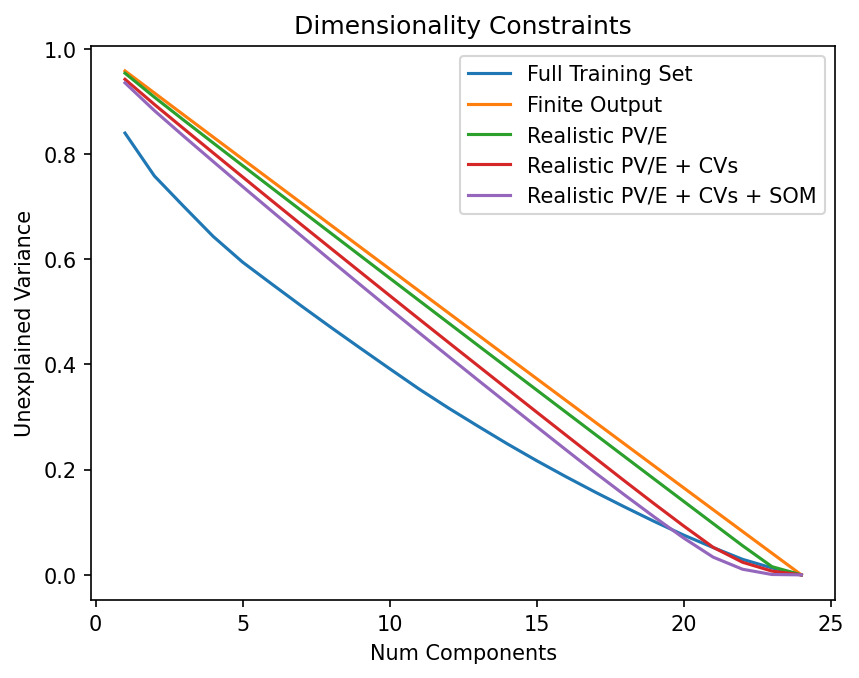

In [193]:
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
plt.rcParams['figure.dpi'] = 150
pca1 = PCA()
pca1.fit(input_train_scaled)
plt.plot(np.arange(1, num_params + 1), 1 - (np.cumsum(pca1.explained_variance_) / np.sum(pca1.explained_variance_)), label = "Full Training Set")

num_trials = int(1e6)
random_inputs = np.random.uniform(low = -2, high = 2, size=(num_trials, num_params))
model_outputs = model(torch.tensor(random_inputs).to(device).float())
expected_outputs_orig, _ = get_stats(model_outputs, output_scaler, n_components=3)
expected_outputs_orig = expected_outputs_orig.detach().cpu().numpy()
finite_filt = np.where((expected_outputs_orig[:, 2] < 500) & (expected_outputs_orig[:, 1] < 500) & (expected_outputs_orig[:, 0] < 500))[0]
expected_outputs_finite = expected_outputs_orig[finite_filt]
finite_filt_params = random_inputs[finite_filt]
pca2 = PCA()
pca2.fit(finite_filt_params)
plt.plot(np.arange(1, num_params + 1), 1 - (np.cumsum(pca2.explained_variance_) / np.sum(pca2.explained_variance_)), label = "Finite Output")

#expected_outputs = model(torch.tensor(random_inputs).to(device).float())[:, :4]
rate_filts = np.array([expected_outputs_finite[:, 0] > 2,
              expected_outputs_finite[:, 0] < 120,
              (np.abs((expected_outputs_finite[:, 1] / expected_outputs_finite[:, 0]) - 3) < 2)])

rate_filt_idx = np.argwhere(np.prod(rate_filts, axis = 0))

inputs_ratefilt = finite_filt_params[rate_filt_idx].squeeze()
#inputs_depression_filt = random_inputs[depression_filts].squeeze()
#inputs_bothfilt = random_inputs[np.intersect1d(depression_filts, rate_filt_idx)].squeeze()
pca3 = PCA()
pca3.fit(inputs_ratefilt)
plt.plot(np.arange(1, num_params + 1), 1 - (np.cumsum(pca3.explained_variance_) / np.sum(pca3.explained_variance_)), label = "Realistic PV/E")

outputs_rate_filt = expected_outputs_finite[rate_filt_idx].squeeze()
cv_scores = np.sum((outputs_rate_filt[:, 3:] - 1)**2, axis = 1)
cv_filt_idx = np.where(cv_scores < 0.5)
inputs_cv_filt = inputs_ratefilt[cv_filt_idx]
outputs_cv_filt = outputs_rate_filt[cv_filt_idx]

pca4 = PCA()
pca4.fit(inputs_cv_filt)
plt.plot(np.arange(1, num_params + 1), 1 - (np.cumsum(pca4.explained_variance_) / np.sum(pca4.explained_variance_)), label = "Realistic PV/E + CVs")

som_filt_idx = np.where(outputs_cv_filt[:, 2] < 30)[0]
inputs_som_filt = inputs_cv_filt[som_filt_idx]
outputs_som_filt = outputs_cv_filt[som_filt_idx]

pca5 = PCA()
pca5.fit(inputs_som_filt)
plt.plot(np.arange(1, num_params + 1), 1 - (np.cumsum(pca5.explained_variance_) / np.sum(pca5.explained_variance_)), label = "Realistic PV/E + CVs + SOM")

plt.legend()
plt.xlabel("Num Components")
plt.ylabel("Unexplained Variance")
plt.title("Dimensionality Constraints")

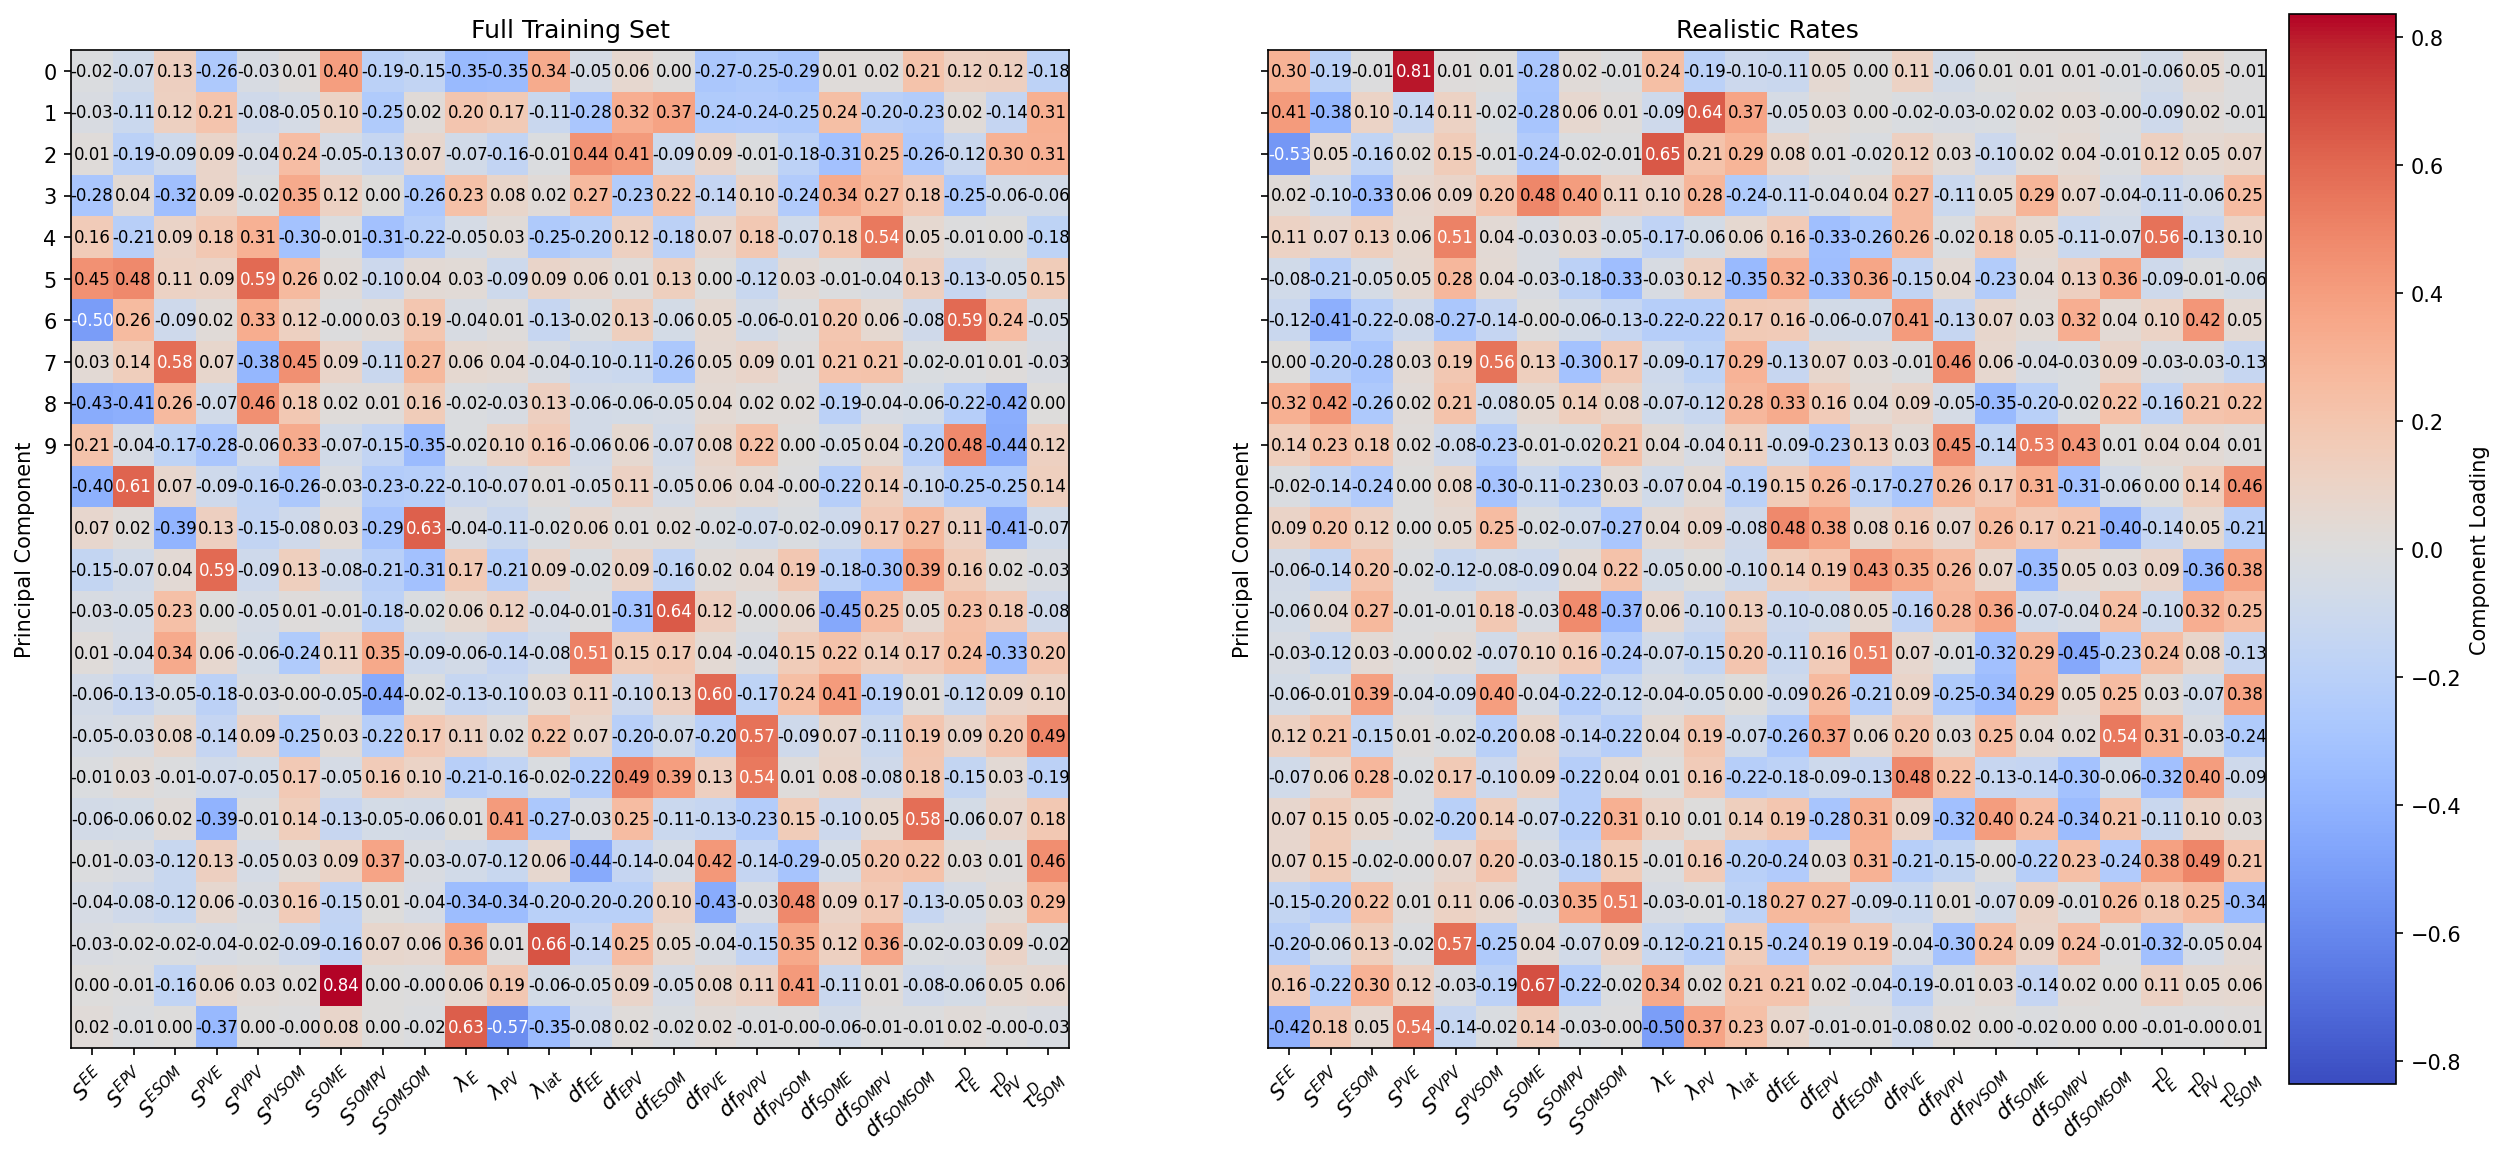

In [194]:
# --- 2. Setup for plotting ---
pcas = [pca1, pca3]
titles = ["Full Training Set", "Realistic Rates"]

# --- 3. Create the 2x2 subplot grid ---
# sharex=True and sharey=True ensure all plots use the same ticks
fig, axes = plt.subplots(1, 2, figsize=(20, 18), sharex=True, sharey=True)

# Find the global min/max across all PCA components for a shared color scale
global_max_abs = 0
for pca in pcas:
    max_val = np.max(np.abs(pca.components_))
    if max_val > global_max_abs:
        global_max_abs = max_val

# --- 4. Loop through the data and axes to create each plot ---
# axes.flatten() turns the 2x2 grid of axes into a simple 1D array
for ax, pca, title in zip(axes.flatten(), pcas, titles):
    data = pca.components_
    
    # Use 'im' to store the last plotted image for the colorbar
    im = ax.imshow(
        data,
        cmap='coolwarm',
        vmin=-global_max_abs,
        vmax=global_max_abs
    )
    
    ax.set_title(title)

    # Add the numerical text to each cell
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            text_color = "white" if abs(val) > global_max_abs * 0.6 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color, fontsize=8)

# --- 5. Configure shared labels and ticks ---
# Set common y-axis label and ticks only for the leftmost column
for ax in axes:
    ax.set_ylabel("Principal Component")
    ax.set_yticks(np.arange(10))

# Set common x-axis labels and ticks only for the bottom row
for ax in axes:
    ax.set_xticks(np.arange(24))
    ax.set_xticklabels(param_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# --- 6. Add a single, shared colorbar ---
# This creates a new axis for the colorbar to make space for it
fig.colorbar(im, ax=axes.ravel().tolist(), label="Component Loading", pad=0.01, aspect=10, fraction=0.046)

#fig.suptitle("PCA Component Comparison Across Datasets", fontsize=16)
# Use tight_layout to automatically adjust spacing
#fig.tight_layout(rect=[0, 0, 1, 0.96]) # rect leaves space for the suptitle

plt.show()

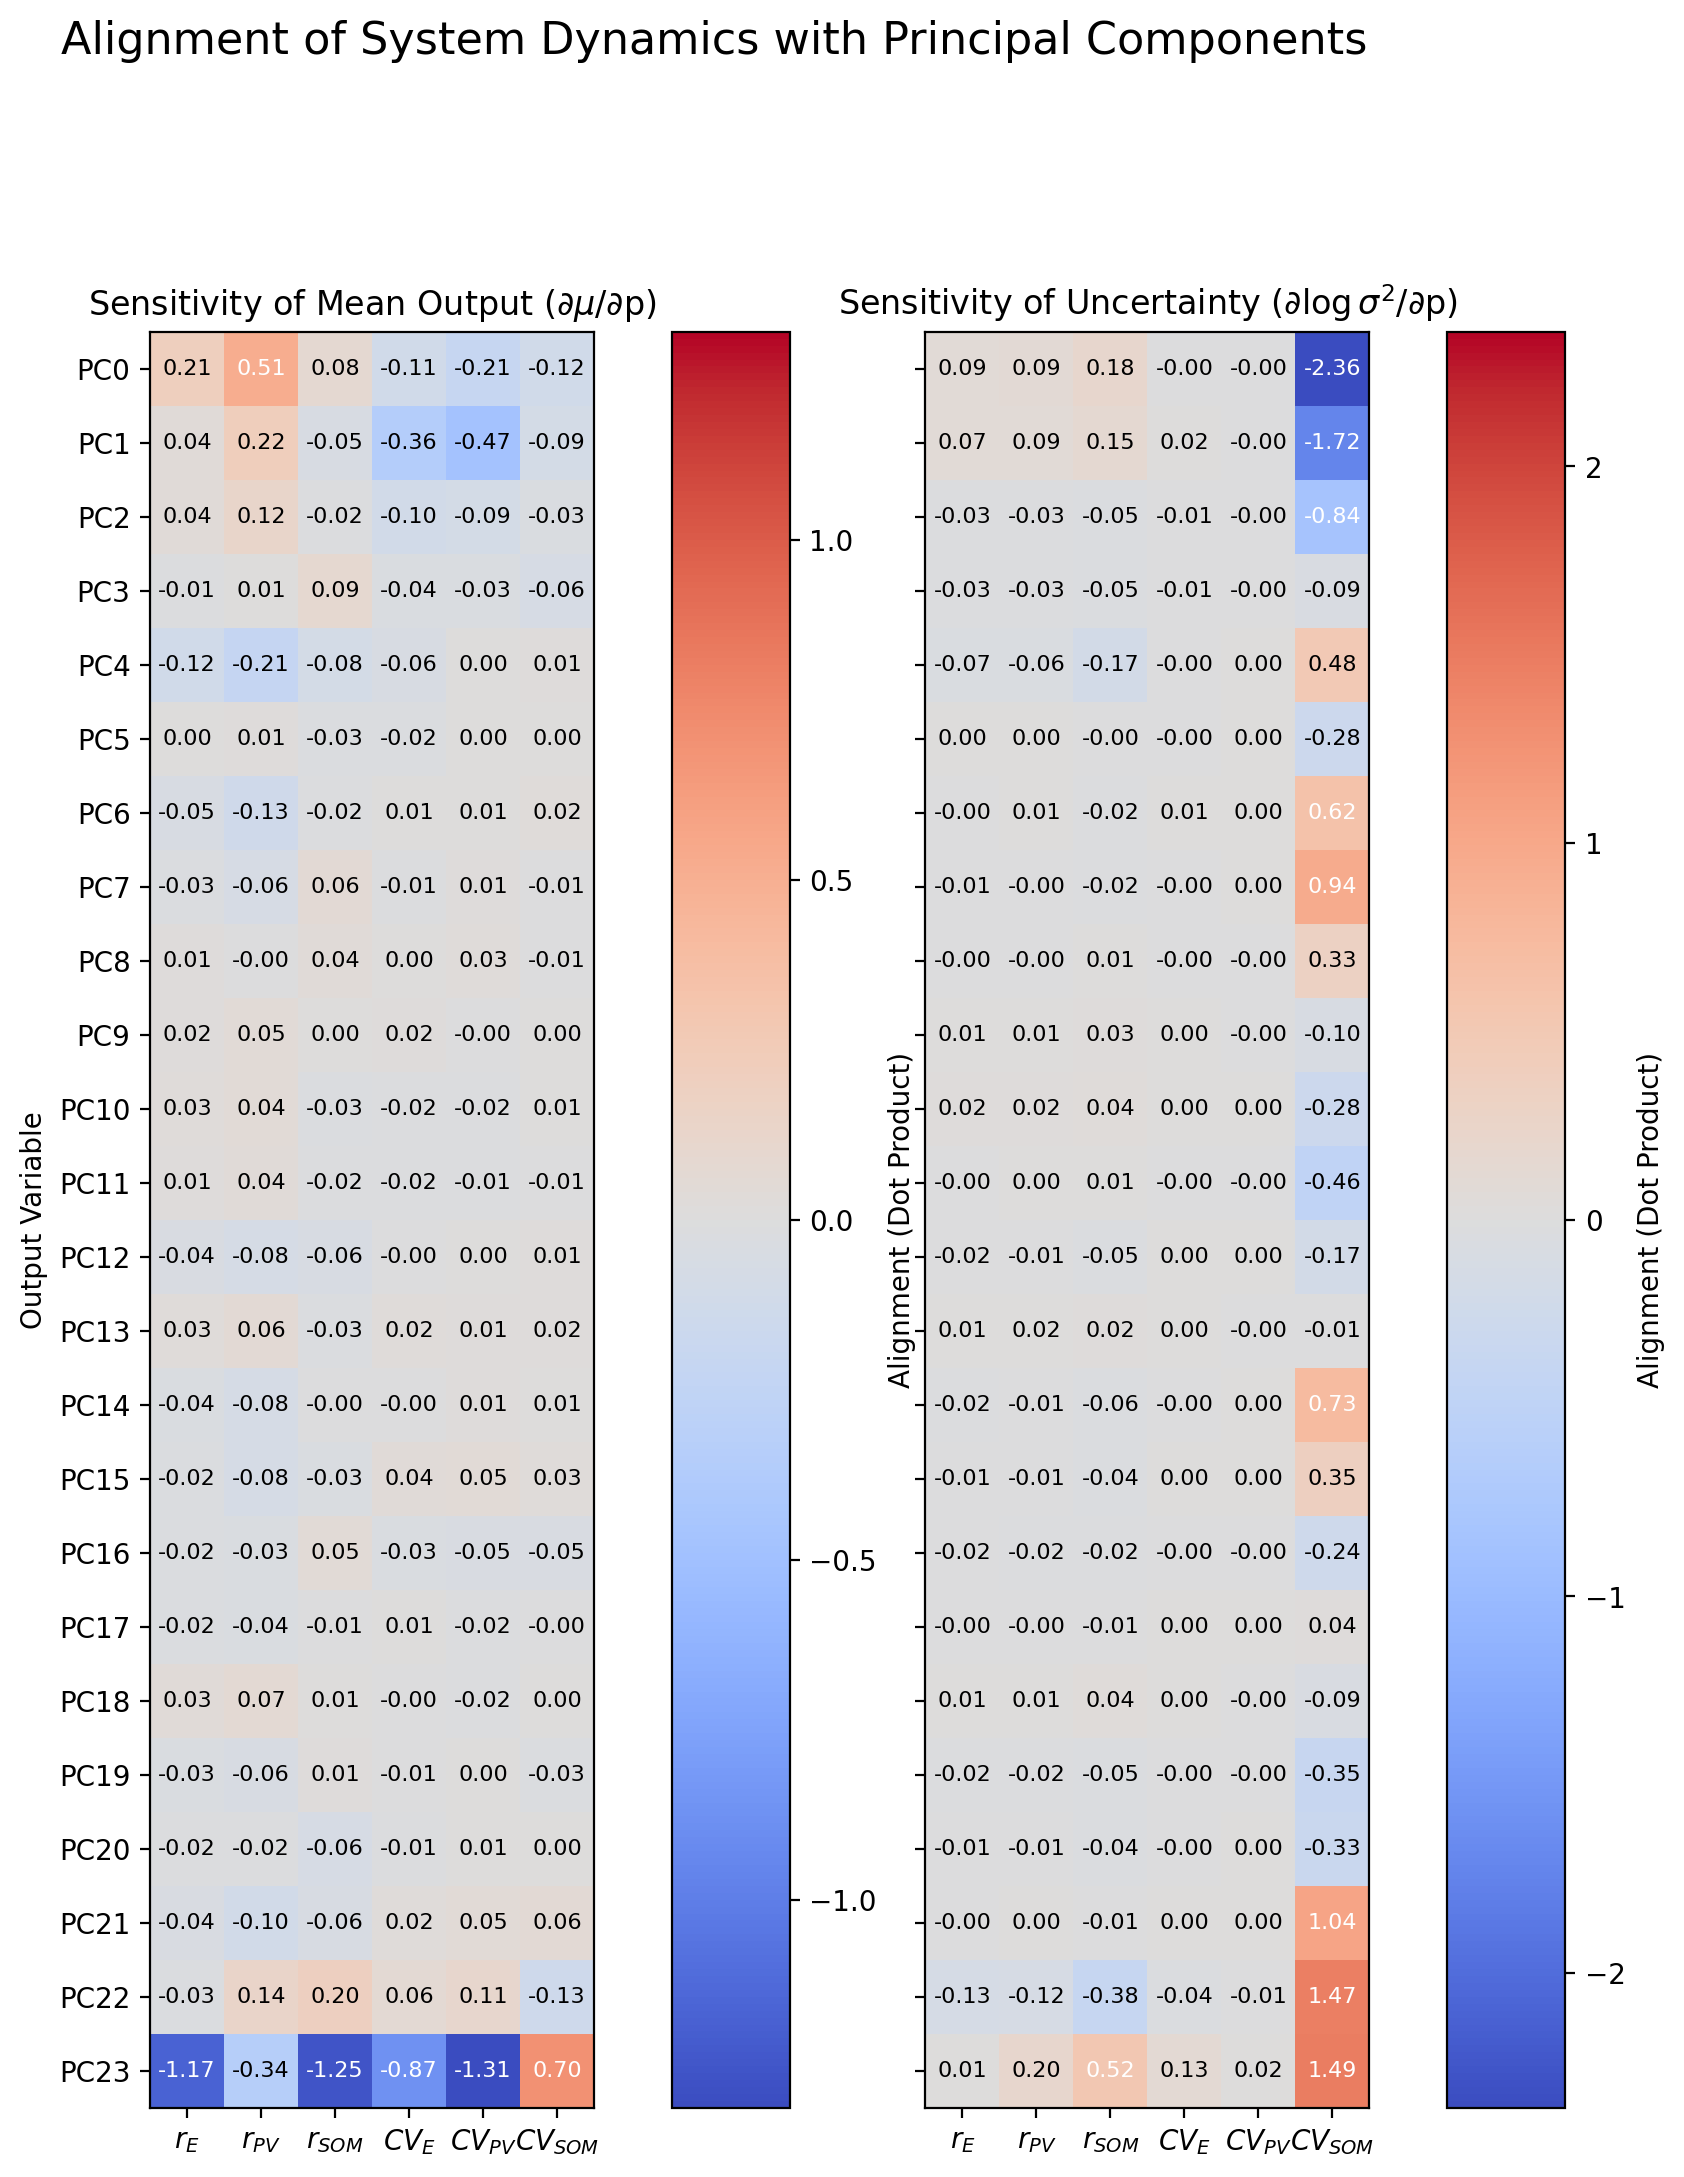

In [195]:
plt.rcParams['figure.dpi'] = 200
mean_alignment = pca3.components_@mean_jacobian_final
log_var_alignment = pca3.components_@std_dev_jacobian_final

def plot_alignment_heatmap(ax, data, title):
    """
    Plots a heatmap of the alignment data on a given Matplotlib axis.
    """
    output_names = ["$r_E$", "$r_{PV}$", "$r_{SOM}$", "$CV_E$", "$CV_{PV}$", "$CV_{SOM}$"]
    max_abs_val = np.max(np.abs(data))
    im = ax.imshow(data, cmap='coolwarm', vmin=-max_abs_val, vmax=max_abs_val)

    fig.colorbar(im, ax=ax, label="Alignment (Dot Product)", aspect=15, pad=0.03)
    ax.set_title(title)
    ax.set_yticks(np.arange(num_params))
    ax.set_yticklabels([f"PC{i}" for i in range(num_params)])
    ax.set_xticks(np.arange(num_outputs))
    ax.set_xticklabels(output_names)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            text_color = "white" if abs(val) > global_max_abs * 0.6 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=text_color, fontsize=8)
    
    return im

fig, axes = plt.subplots(1, 2, figsize=(14, 12), sharey=True)
fig.suptitle("Alignment of System Dynamics with Principal Components", fontsize=16)

# Plot the alignment for the mean
im1 = plot_alignment_heatmap(axes[0], mean_alignment, "Sensitivity of Mean Output ($\partial\mu$/$\partial$p)")
axes[0].set_ylabel("Output Variable")

# Plot the alignment for the log-variance
im2 = plot_alignment_heatmap(axes[1], log_var_alignment, "Sensitivity of Uncertainty ($\partial \log \sigma^2/\partial $p)")

# Add a shared colorbar
#fig.colorbar(im1, ax=axes, label="Alignment (Dot Product)", aspect=20, pad=0.02)
plt.subplots_adjust(left = -0.3, wspace=-0.7, top=0.85)
plt.show()


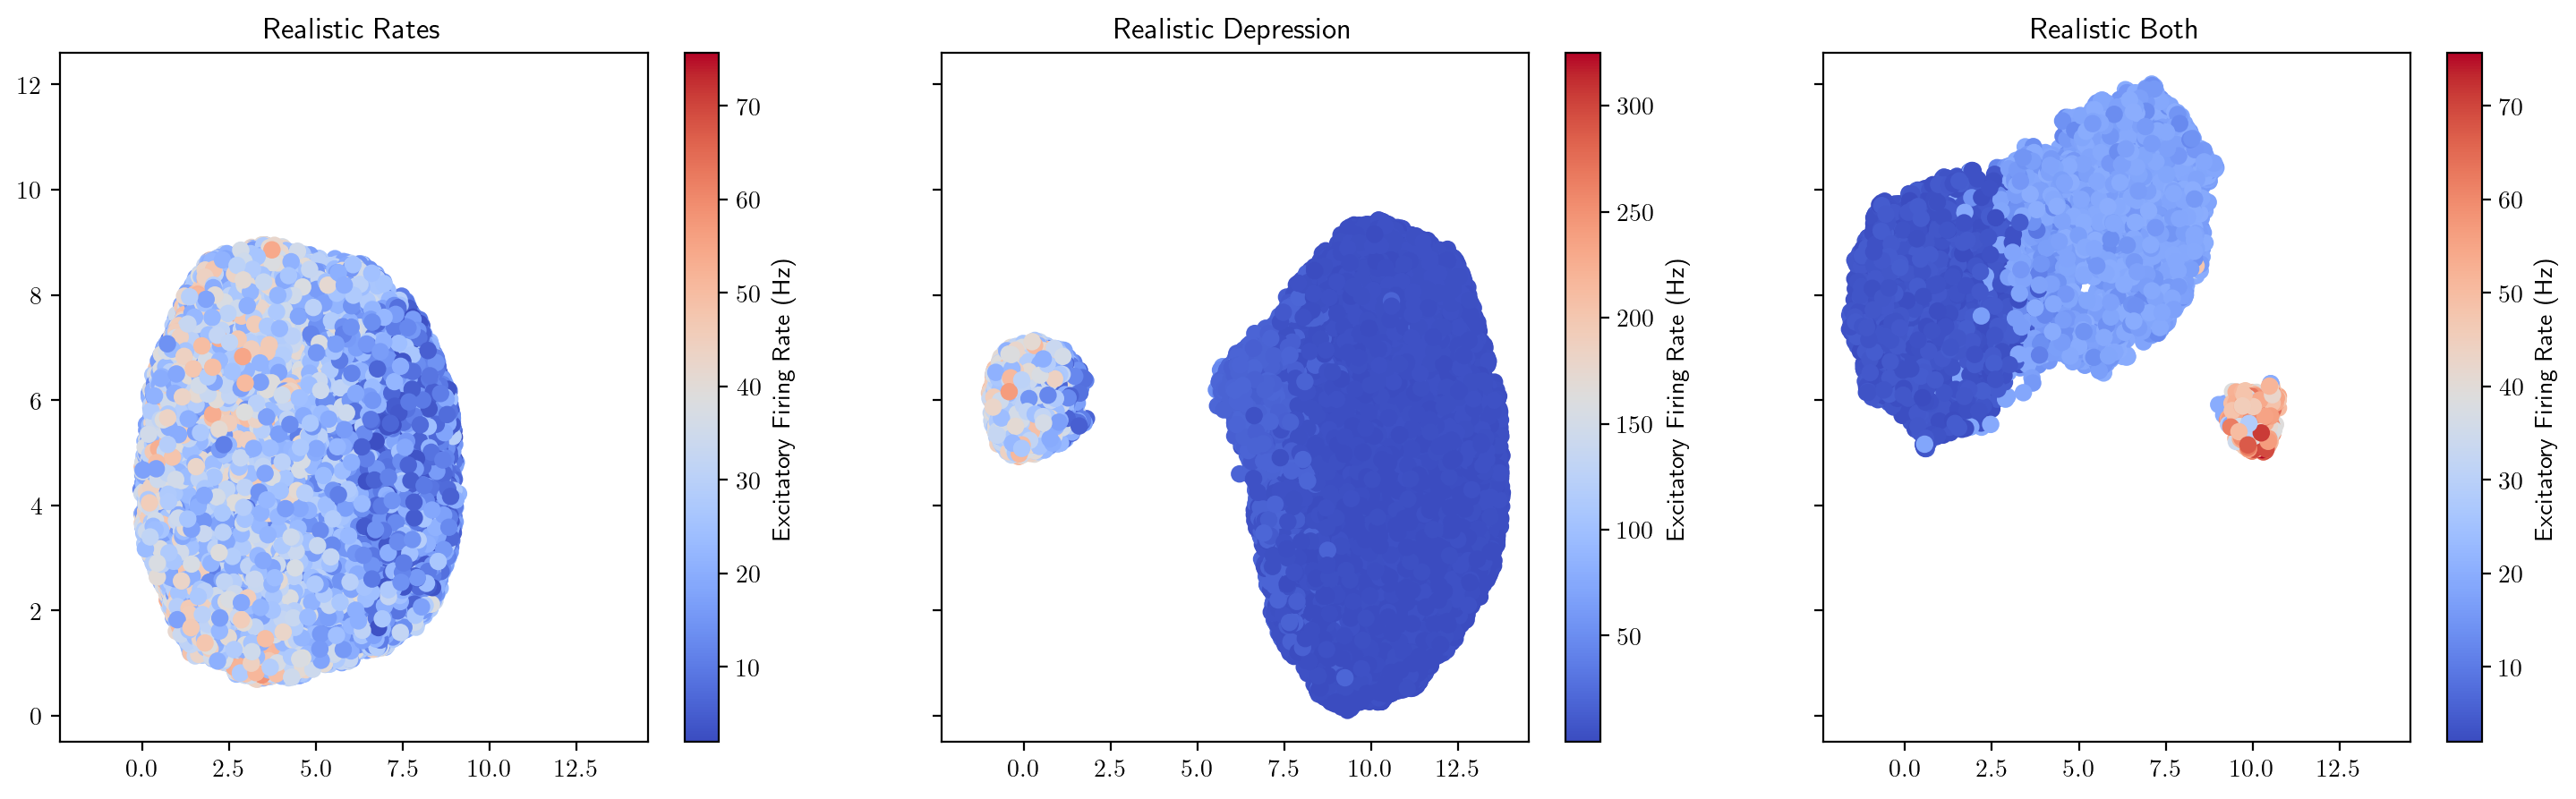

In [459]:
# Visualize clusters
import umap
fig, ax = plt.subplots(1, 3, figsize=(18,5), sharex = True, sharey = True)
all_r_E = np.concatenate([expected_outputs_orig[idxs, 0] for idxs in inputs_idxs])
vmin = all_r_E.min()
vmax = all_r_E.max()

def plot_umap(inputs, idxs, ax):
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(inputs)
    r_E = expected_outputs_orig[idxs, 0]
    vmin = r_E.min()
    vmax = r_E.max()
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c = r_E, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    fig.colorbar(scatter, ax=ax, label="Excitatory Firing Rate (Hz)")

inputs = [inputs_ratefilt, inputs_depression_filt, inputs_bothfilt]
inputs_idxs = [rate_filt_idx.squeeze(), depression_filts, np.intersect1d(rate_filt_idx, depression_filts)]
titles = ["Realistic Rates", "Realistic Depression", "Realistic Both"]
for i, (data, idxs, title) in enumerate(zip(inputs, inputs_idxs, titles)):
    scatter = plot_umap(data, idxs, ax[i])
    ax[i].set_title(title)

In [460]:
# Find clusters
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import hdbscan
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15
)
cluster_labels = clusterer.fit_predict(inputs_bothfilt)
num_clusters = len(np.unique(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise_points = np.sum(cluster_labels == -1)
print(f"HDBSCAN Number of clusters found: {num_clusters}")

params_cluster_0 = inputs_bothfilt[cluster_labels == 0]
params_cluster_1 = inputs_bothfilt[cluster_labels == 1]

centroid_0 = np.mean(params_cluster_0, axis=0)
centroid_1 = np.mean(params_cluster_1, axis=0)

distances_0 = np.linalg.norm(params_cluster_0 - centroid_0, axis=1)
closest_index_0 = np.argmin(distances_0)
center_point_0 = params_cluster_0[closest_index_0] # High rate center
distances_1 = np.linalg.norm(params_cluster_1 - centroid_1, axis=1)
closest_index_1 = np.argmin(distances_1)
center_point_1 = params_cluster_1[closest_index_1] # Low rate center

num_steps = 100
path_params = np.array([np.linspace(start, end, num_steps) for start, end in zip(center_point_0, center_point_1)]).T
path_params = torch.tensor(path_params).to(device).float()
path_outputs = model(path_params)
path_output_means = path_outputs[:, :4]
path_output_mean_origs = np.exp(output_scaler.inverse_transform(path_output_means.detach().cpu().numpy()))

HDBSCAN Number of clusters found: 3


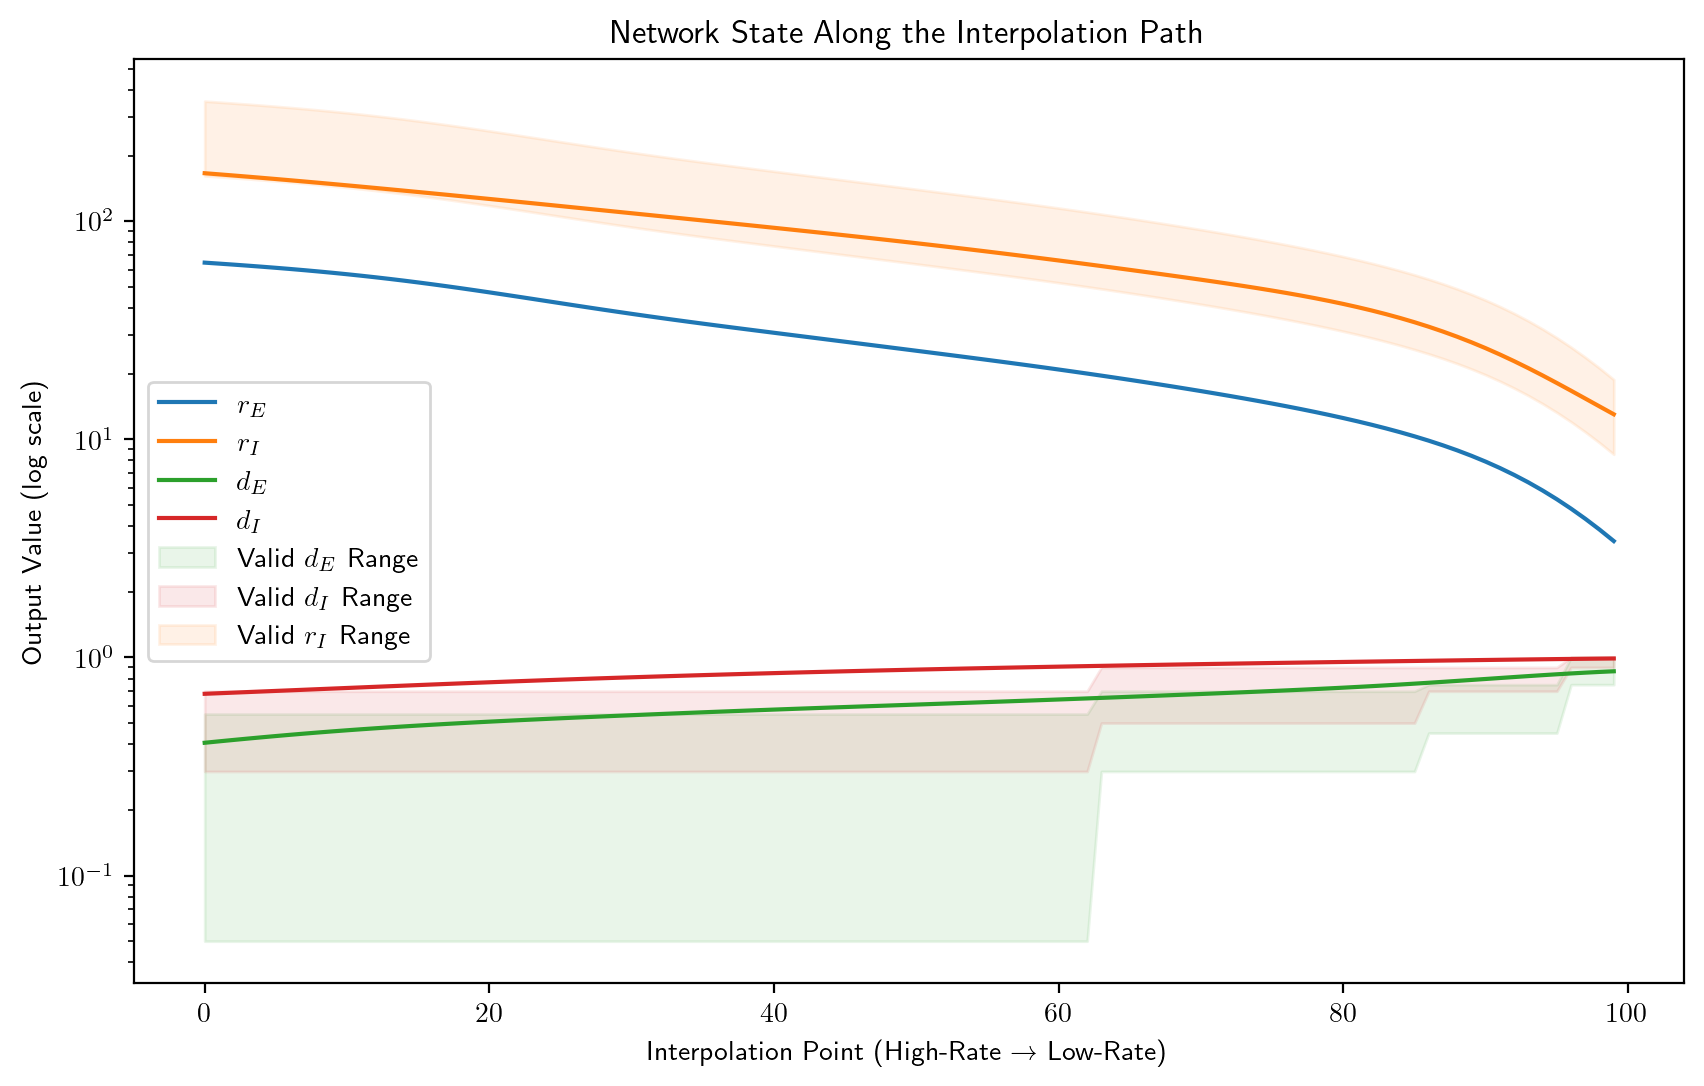

In [461]:
def get_realism_bounds(r_E_values):
    d_E_min, d_E_max = np.zeros_like(r_E_values), np.zeros_like(r_E_values)
    d_I_min, d_I_max = np.zeros_like(r_E_values), np.zeros_like(r_E_values)
    
    for i, r_E in enumerate(r_E_values):
        if r_E < 5:
            d_E_min[i], d_E_max[i] = 0.75, 1
            d_I_min[i], d_I_max[i] = 0.9, 1
        elif r_E < 10:
            d_E_min[i], d_E_max[i] = 0.45, 0.75 # 0.6 +/- 0.15
            d_I_min[i], d_I_max[i] = 0.7, 0.9  # 0.8 +/- 0.1
        elif r_E < 20:
            d_E_min[i], d_E_max[i] = 0.3, 0.7 # 0.325 +/- 0.2
            d_I_min[i], d_I_max[i] = 0.5, 0.9   # 0.7 +/- 0.2
        else: # r_E >= 20
            d_E_min[i], d_E_max[i] = 0.05, 0.55  # 0.2 +/- 0.25
            d_I_min[i], d_I_max[i] = 0.3, 0.7   # 0.5 +/- 0.2
            
    return d_E_min, d_E_max, d_I_min, d_I_max

# --- 2. Create the plot ---
fig, ax = plt.subplots(figsize=(10, 6))
x_axis = np.arange(num_steps)

# Plot the main output curves
labels = ["$r_E$", "$r_I$", "$d_E$", "$d_I$"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i in range(path_output_mean_origs.shape[1]):
    ax.semilogy(x_axis, path_output_mean_origs[:, i], label=labels[i], color=colors[i])

# --- 3. Calculate and plot the valid regions for depression ---
path_r_E = path_output_mean_origs[:, 0]
d_E_min, d_E_max, d_I_min, d_I_max = get_realism_bounds(path_r_E)

# Shade the valid regions for d_E and d_I
ax.fill_between(x_axis, d_E_min, d_E_max, color=colors[2], alpha=0.1, label='Valid $d_E$ Range')
ax.fill_between(x_axis, d_I_min, d_I_max, color=colors[3], alpha=0.1, label='Valid $d_I$ Range')
ax.fill_between(x_axis, path_r_E * 2.5, path_r_E * 5.5, color=colors[1], alpha = 0.1, label = 'Valid $r_I$ Range')


# --- 4. Find and highlight the overall "forbidden zone" ---
# Check all constraints at each point on the path
path_r_I = path_output_mean_origs[:, 1]
path_d_E = path_output_mean_origs[:, 2]
path_d_I = path_output_mean_origs[:, 3]

is_valid = (
    (path_r_E > 2) & (path_r_E < 120) &
    ((path_r_I / path_r_E) > 2.5) & ((path_r_I / path_r_E) < 5.5) &
    (path_d_E > d_E_min) & (path_d_E < d_E_max) &
    (path_d_I > d_I_min) & (path_d_I < d_I_max) &
    (path_d_E < path_d_I)
)

# Shade the area where *any* constraint is violated
#ax.fill_between(x_axis, ax.get_ylim()[0], ax.get_ylim()[1], where=~is_valid, 
#                facecolor='grey', alpha=0.4, label='Forbidden Zone')


# --- 5. Finalize plot ---
ax.set_xlabel("Interpolation Point (High-Rate → Low-Rate)")
ax.set_ylabel("Output Value (log scale)")
ax.set_title("Network State Along the Interpolation Path")
ax.legend()

In [463]:
bridge_indices = np.setdiff1d(depression_filts, rate_filt_idx)

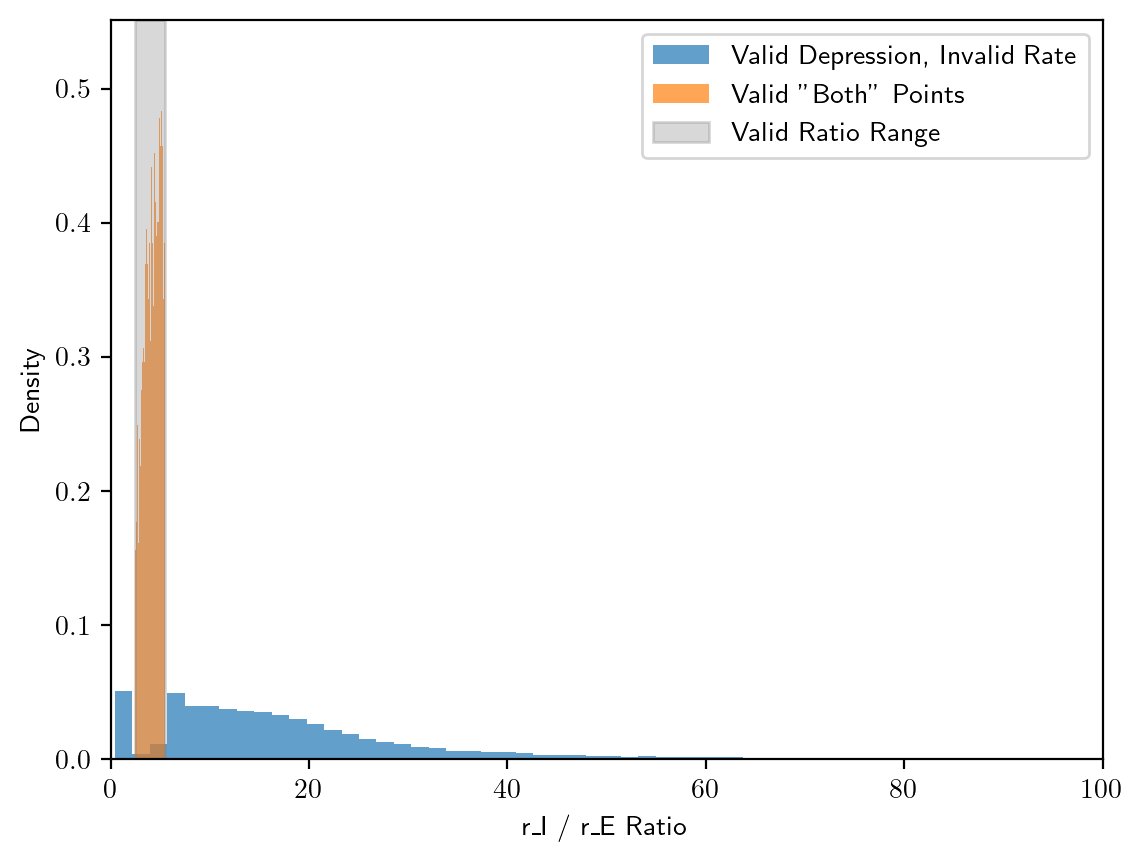

In [477]:
bridge_indices
bridge_params = random_inputs[bridge_indices]
bridge_outputs = expected_outputs_orig[bridge_indices]

bridge_r_E = bridge_outputs[:, 0]
bridge_r_I = bridge_outputs[:, 1]
bridge_ratio = bridge_r_I / bridge_r_E

valid_both_outputs = expected_outputs_orig[np.intersect1d(depression_filts, rate_filt_idx)]
valid_ratio = valid_both_outputs[:, 1] / valid_both_outputs[:, 0]

plt.hist(bridge_ratio, bins=1000, label='Valid Depression, Invalid Rate', alpha=0.7, density=True)
plt.hist(valid_ratio, bins=100, label='Valid "Both" Points', alpha=0.7, density=True)
plt.xlim(0, 100)
plt.axvspan(2.5, 5.5, color='gray', alpha=0.3, label='Valid Ratio Range')
plt.xlabel("r_I / r_E Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()

In [469]:
bridge_ratio

array([17.901505, 12.179657, 15.782665, ..., 20.67619 , 19.791365, 35.152477], dtype=float32)